In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

<div style="text-align: right;">
- Aryan Hemani (706305360)
- Nikolaos Papadatos(506315713)
- Raghavi Rajumohan (306305814)
</div>

In [2]:
import pandas as pd
import pyblp
import numpy as np 
import matplotlib.pyplot as plt
pyblp.options.digits = 2
pyblp.options.verbose = False
pyblp.__version__

'1.1.0'

## Envinornment 

### 1. Demand

We study the competition between pizza bakers in Westwood that offer delivery services to consumers situated in Westwood. Consumer $i$ indirect utility function for pizza $j$ in market $t$ is as follows:

$$
u_{ijt} = \beta_i^p \times p_{jt} + \beta^d \times deliverytime_{jt} + \beta^r \times rating_{jt} + \xi_{jt} + \epsilon_{ijt} \tag{1}
$$

$$
u_{i0t} = \alpha_i + \epsilon_{i0t} \tag{2}
$$

Here, and following the structure of the BLP model where,

- $p_{jt}$ denotes the price 
- $\xi_{jt}$ denotes unobserved product quality 
- $deliverytime_{jt}$ and $rating_{jt}$ denote the observed product characteristics discussed above. 

We assume the $\epsilon_{ijt}$ are distributed i.i.d. extreme value and allow for preference heterogeneity over prices and a constant term for the outside good denoted by 0. Specifically, we assume that

$$
\beta_i^p = \beta^p + \pi \times \frac{1}{Income_i} \tag{3}
$$

$$
\alpha_i \sim N(0, \sigma^2) \tag{4}
$$

where again similar to the BLP problem, $\alpha_i$ and $\frac{1}{Income_i}$ denote random coefficients.



### 2. Supply 

We model supply using a standard multiproduct-firms differentiated-product Bertrand model. Pizza bakers can produce pizzas at marginal costs:

$$
mc_{jt} = \gamma_0 + \gamma_1 \times rating_{jt} + \gamma_3 \times hourlywages_{jt} + \omega_{jt} \tag{5}
$$

Pizza bakers take their marginal costs and the exogenous demand shifters (rating and deliverytime) as given and choose the profit-maximizing prices.

## Analysis 

### Question 1: Instrumental Variables

#### We use demand and supply instruments to identify the structural model parameters.

**1. Demand: Explain (in theory) why BLP instruments can be used to estimate demand parameters taking price endogeneity into account.**

Price endogeneity occurs when unobserved factors that influence demand also affect the prices set by firms. If these unobserved factors are correlated with the error term in the demand equation, the coefficient estimates will be biased and inconsistent. Therefore, it is crucial to identify variables that correlate with price but are not related to other elements in the demand equation.

BLP instruments address the endogeneity of prices in demand estimation by utilizing the exogenous variation in the characteristics of other goods in the market. The fundamental idea is that while a product's characteristics (such as quality, brand, features etc) can impact its price, the characteristics of other (ex. rival) products can serve as instruments. These 'other' product characteristics (potentially) influence the market environment without being directly correlated with the error term of the product in question. By leveraging this exogenous variation, BLP instruments help isolate the true effect of price on demand, thereby correcting for endogeneity.

**2. Demand: In this exercise, we use two sets of instruments:**

- Sums over characteristics of non-rival goods: $Z_{jt}^{BLP, other}(X) = \sum_{(k \in J_{ft, j})} x_{kt}$
- Sums over characteristics of rival goods: $Z_{jt}^{BLP, rival}(X) = \sum_{(k \notin J_{ft})} x_{kt}$

**Building on these definitions, explain verbally how `demand_instruments0`-`demand_instruments3` as well as `supply_instruments0`-`supply_instruments3` in `products_pizza.csv` are exactly constructed.**


The first set of instruments (non-rival goods) sums the characteristics of all other products within the same market (e.g., the same city or region, in our example Westwood), excluding the product we study. Formally, the formula identifies all products $k$ in the same market $t$ except for the product $j$ in question and for each product , it sums up their characteristics $x_{kt}$. These instruments include cost shifters such as variables affecting marginal costs (e.g., product, packaging, distribution costs) and cost proxies like city density for storage costs or salary for labor costs (Nevo 2000). In our dataset, `demand_instruments0`-`demand_instruments3` reflect these cost shifters. For instance, city density can influence storage costs, and labor salaries can impact overall labor costs, providing exogenous variation useful for correcting price endogeneity.

The second set of instruments sums the characteristics of rival goods, referring to competing products that are not in the same market as our product but are still relevant for analysis. In our example, these could be the characteristics of pizzas available in neighboring cities (e.g., Brenwood, Santa Monica). The formula identifies all products $k$ that are not in the immediate market set $J_{ft}$ of product $𝑗$, and sums up their characteristics $x_{kt}$. Intuition behind these instruments is that firms set the price of a product based on the characteristics of competing products from competitors. While these characteristics influence the firm's pricing strategy, they do not directly affect consumer valuation for the firm's own product (BLP 1995). For example, if a pizza company sets its prices considering the quality and features of pizzas offered by firms in neighboring cities, these characteristics help determine the competitive landscape and pricing strategies without directly influencing the consumer's choice for the specific pizza in question.

**3. What are shocks can be used as demand and supply instruments and how to the relate to `demand_instruments4` and `supply_instruments4`.**

For a demand instrument to be valid, it needs to capture the impact of exogenous demand shocks, such as local economic conditions or seasonal changes, which influence consumer purchasing behavior independently of the product's price. For example, consider UCLA temporarily raising tuition fees to cover the costs of damages caused by recent protests. This income shock reduces the disposable income of students, affecting their purchasing behavior for goods like pizza. This exogenous variation would be captured by demand_instruments4.

Similarly, a supply instrument needs to capture the impact of exogenous supply shocks, such as changes in input costs or regulatory impacts, which affect production costs and supply independently of market demand. Continuing with the UCLA example, the increased tuition might lead more students to seek part-time employment, increasing the local labor supply and potentially decreasing the wages that pizza stores pay their employees. This exogenous variation in labor costs would be captured by supply_instruments4.

### In our simulation - we assume that our product is a slice of pizza 

### Question 2: Model Estimation

**Formulate the model, which requires specifying the linear demand parameters, the non-linear demand parameters, and the marginal cost function.**

In [3]:
# Load the dataset
products_pizza = pd.read_csv('products_pizza.csv',index_col=0)
agents_pizza = pd.read_csv('agents_pizza.csv',index_col=0)

In [4]:
# Display the first few rows of the dataset to inspect the variables
products_pizza.head()

,market_ids,firm_ids,shares,demand_instruments0,demand_instruments1,demand_instruments2,demand_instruments3,demand_instruments4,supply_instruments0,supply_instruments1,supply_instruments2,supply_instruments3,supply_instruments4,prices,deliverytime,rating,hourlywages,ratingmin
0,0,0,0.008535,2.873646,1.787415,7.934456,10.569206,0.576978,2.031744,1.787415,10.655004,10.569206,0.325810,5.503707,0.325810,0.143190,0.576978,0.500000
1,0,0,0.004494,2.309629,1.298275,7.934456,10.569206,0.875389,1.733333,1.298275,10.655004,10.569206,0.889827,6.105174,0.889827,0.632330,0.875389,0.632330
2,0,0,0.006251,2.447748,1.268717,7.934456,10.569206,0.608565,2.000156,1.268717,10.655004,10.569206,0.751708,7.009777,0.751708,0.661888,0.608565,0.661888
3,0,0,0.006970,2.436824,1.496765,7.934456,10.569206,0.251660,2.357062,1.496765,10.655004,10.569206,0.762632,5.198886,0.762632,0.433840,0.251660,0.500000
4,0,0,0.009103,2.729977,1.871248,7.934456,10.569206,0.296130,2.312592,1.871248,10.655004,10.569206,0.469479,5.189788,0.469479,0.059357,0.296130,0.500000


In [5]:
agents_pizza.head()

,market_ids,nodes0,nodes1,weights,invincome
0,0,-4.512746,-4.512746,4.993367e-10,0.959112
1,0,-4.512746,-3.205429,6.232572e-08,0.553344
2,0,-4.512746,-2.076848,1.115424e-06,0.652731
3,0,-4.512746,-1.023256,5.454565e-06,0.490740
4,0,-4.512746,-0.000000,9.080216e-06,0.646650


**Formulate the agent model (which specifies the variables involving interacted with random coefficients or patient demographics)**

In [6]:
# Add clustering_ids column to products_pizza
products_pizza['clustering_ids'] = products_pizza['market_ids']

# Define the product formulations for demand (X1 and X2) and marginal costs (X3)
product_formulations = (
    pyblp.Formulation('0 + prices + deliverytime + rating'),  # X1: Linear demand model
    pyblp.Formulation('1 + prices'),  # X2: Non-linear demand model
    pyblp.Formulation('1 + rating + hourlywages')  # X3: Marginal cost model
)

# Define the agent formulation
agent_formulation = pyblp.Formulation('0 + invincome')

# Create the problem instance
problem = pyblp.Problem(
    product_formulations=product_formulations,
    product_data=products_pizza,
    agent_formulation=agent_formulation,
    agent_data=agents_pizza
)

**Specify starting values and the dimensionality of the parameter space.**

In [7]:
# Specify starting values for the optimization
sigma = np.array([[1, 0], [0, 0]])  # Sigma is a 2x2 matrix for non-linear variables
pi = np.array([[0], [-1]])  # Pi is a 2x1 matrix/vector for the interaction terms
beta = np.array([-1, -1, 1]).reshape(-1, 1)  # Beta is a 3x1 vector for linear parameters

In [8]:
# Estimate the model
results = problem.solve(
    sigma=sigma,
    pi=pi,
    beta=beta,
    costs_bounds=(0.001, None),
    initial_update=True
)

# Display the estimation results
print(results)

Problem Results Summary:
GMM   Objective    Projected    Reduced Hessian  Reduced Hessian  Clipped  Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Gradient Norm  Min Eigenvalue   Max Eigenvalue   Shares    Costs   Condition Number  Condition Number 
----  ---------  -------------  ---------------  ---------------  -------  -------  ----------------  -----------------
 2    +3.7E+00     +4.5E-11        +4.9E+01         +2.3E+05         0        0         +8.1E+04          +5.6E+03     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:00:05       Yes          69           87          9987         31408   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
Sigma:      1        prices   |   Pi:    invincome 
------  ----------  --------  |  ------  ----------
 

**1. Explain in one sentence (each) the linear demand parameter ($\beta$) effect sizes.**

The coefficient for prices ($\beta_{i}^p$) indicates the sensitivity of demand to price changes. The model estimates that for every one-unit increase in price, the demand for pizza decreases by 0.12 units. This negative value indicates that higher prices lead to lower demand for pizza, a resullt consisten with economic theory intuition.

The coefficient for delivery time ($\beta^d$) represents how changes in delivery time affect demand. The model estimates that for every one-unit increase in delivery time, the demand for pizza decreases by 1 unit. This negative value suggests that longer delivery times significantly reduce demand.

The coefficient for rating ($\beta^r$) shows the impact of product ratings on demand. The model estimates that for every one-unit increase in rating, the demand for pizza increases by 0.98 units. This positive value implies that higher ratings lead to higher demand, reflecting consumers' preference for better-rated products.

**2. Explain in one sentence (each) the marginal cost parameter ($\gamma$) effect sizes.**

The coefficient for $rating$ indicates the sensitivity of marginal costs to changes in the log of product ratings. The model estimates that for every one-unit increase in the log of the rating, the marginal cost increases by 1 units. This suggests that better-rated products may have higher production costs, though the large standard error indicates significant uncertainty in this estimate.

The coefficient for $hourly wages$ shows the impact of wage changes on marginal costs. The model estimates that for every one-unit increase in hourly wages, the marginal cost decreases by 2 units. This negative value is somewhat counterintuitive, suggesting that higher wages are associated with lower marginal costs, but the large standard error implies considerable uncertainty in this estimate.

**3. Explain in one sentence (each) the nonlinear coefficient estimates (sigma and $\pi$)**

The matrix $\Sigma$ represents the variance-covariance matrix of the random coefficients. In our model, the estimated values for all elements of $\Sigma$ are zero, indicating that there is no significant variance in the random coefficients for the demand model. This suggests that the model does not find evidence of heterogeneity in consumer preferences that is explained by the random coefficients.

The matrix $\Pi$ represents the interaction between the random coefficients and the observed demographics (in this case, income). The estimated values for all elements of $\Pi$ are zero, indicating that there is no significant interaction between income and the random coefficients for the demand model. This suggests that the model does not find evidence that income levels influence the random variation in consumer preferences.

### Question 3: Elasticities and Diversion Ratios

**1. Summarize the own and cross-price elasticities. You may use a graph for this or simply calculate an average across products. Discuss in one sentence how you interpret the own and the cross-price elasticity.**

***Calculating Elasticities:***

#### Own Price Elasticity of Demand

The own price elasticity of demand measures the responsiveness of the quantity demanded for a good when its own price changes. It is calculated using the following formula:

$$ E_{ii} = \frac{\partial Q_i}{\partial P_i} \times \frac{P_i}{Q_i} $$

#### Cross Price Elasticity of Demand

The cross-price elasticity of demand measures the responsiveness of the quantity demanded for one good when the price of another good changes. It is calculated using the following formula:

$$ E_{ij} = \frac{\partial Q_i}{\partial P_j} \times \frac{P_j}{Q_i} $$


In the matrix of elasticities $ E $:

$$ 
E = \begin{pmatrix}
e_{11} & e_{12} & e_{13} \\
e_{21} & e_{22} & e_{23} \\
e_{31} & e_{32} & e_{33} \\
\end{pmatrix}
$$

The ***diagonal elements*** $ e_{ii} $ (e.g., $ e_{11} $, $ e_{22} $, $ e_{33} $) are the ***own price elasticities***.

The ***off-diagonal elements*** $ e_{ij} $ (e.g., $ e_{12} $, $ e_{13} $, $ e_{21} $, etc.) are the ***cross-price elasticities***.


In [9]:
# Compute elasticities and diversion ratios
elasticities = results.compute_elasticities()

# Take an example market (market_id = 0, for instance)
single_market = products_pizza['market_ids'] == 0

market_id = 0

# Extract elasticities matrix for the chosen market
elasticities_market = elasticities[single_market]

# Own-Price Elasticities (diagonal elements of the elasticities matrix)
own_price_elasticities = np.diagonal(elasticities_market)

# Convert to DataFrame for better display
df = pd.DataFrame(elasticities_market)
df = df.iloc[:5, :5]

def highlight_diagonal(x):
    # Create an empty DataFrame of styles with the same shape as x
    styles = pd.DataFrame('', index=x.index, columns=x.columns)
    # Get the diagonal indices
    diag_indices = np.diag_indices_from(x.values)
    # Set the diagonal elements to have the desired style
    for i, j in zip(diag_indices[0], diag_indices[1]):
        styles.iloc[i, j] = 'color: blue; font-weight: bold'
    # Set the non-diagonal elements to have a different style
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if i != j:
                styles.iloc[i, j] = 'color: green'
    return styles

# Apply the highlighting function
styler = df.style.apply(highlight_diagonal, axis=None)


# Own-Price Elasticities (diagonal elements of the elasticities matrix)
own_price_elasticities = np.diagonal(elasticities_market)

# Cross-Price Elasticities (off-diagonal elements of the elasticities matrix)
cross_price_elasticities = elasticities_market - np.diag(np.diagonal(elasticities_market))

# Average Own-Price Elasticity
average_own_price_elasticity = np.mean(own_price_elasticities)

# Average Cross-Price Elasticity
average_cross_price_elasticity = np.mean(cross_price_elasticities[cross_price_elasticities != 0])

# Print results
print("\033[1;34mAverage Own-Price Elasticity (Market ID: {})\033[0m: {:.2f}".format(market_id, average_own_price_elasticity))
print("\033[1;32mAverage Cross-Price Elasticity (Market ID: {})\033[0m: {:.2f}".format(market_id, average_cross_price_elasticity))

print("")
print("")
print("Elasticity Matrix:")

# Display the styled DataFrame
styler

Average Own-Price Elasticity (Market ID: 0): -2.14
Average Cross-Price Elasticity (Market ID: 0): 0.05


Elasticity Matrix:


,0,1,2,3,4
0,-2.092032,0.030822,0.049266,0.040393,0.052650
1,0.052772,-2.221275,0.050199,0.040364,0.052605
2,0.052816,0.031432,-2.402114,0.040206,0.052391
3,0.052359,0.030559,0.048614,-2.061362,0.052608
4,0.052351,0.030550,0.048592,0.040354,-2.047980


1. **Summarize the Own and Cross-Price Elasticities**:
   - **Own-Price Elasticities**:
     - The diagonal values in the elasticities matrix represent the own-price elasticities for pizzas, which are negative and significant.
     - The average own-price elasticity for Market ID: 0 is -2.14.
     - **Interpretation**: On average, a 1% increase in the price of a specific type of pizza leads to a 2.14% decrease in the quantity demanded of that pizza. This indicates that the demand for pizza is relatively elastic with respect to its own price. The negative sign and magnitude of the elasticities suggest that consumers are sensitive to price changes, with demand decreasing significantly as prices increase.
     


   - **Cross-Price Elasticities**:
     - The off-diagonal values in the elasticities matrix represent the cross-price elasticities for pizzas.
     - The average cross-price elasticity for Market ID: 0 is 0.05.
     - **Interpretation**: On average, a 1% increase in the price of another type of pizza leads to a 0.05% increase in the quantity demanded of a specific pizza, suggesting very weak substitution effects between different types of pizzas. This low cross-price elasticity indicates that consumers do not significantly shift their demand from one type of pizza to another in response to price changes, highlighting strong product differentiation and consumer loyalty to specific pizza types.
     

**Conclusion:**

- The relatively high own-price elasticities emphasize that pizza demand is quite sensitive to price changes, meaning that price increases could lead to substantial reductions in sales.
- The low cross-price elasticities indicate weak substitution among different pizza products, suggesting that each pizza type has a loyal customer base with limited overlap with other types.

**Implications for Market Strategy:**

- Given the high own-price elasticities, pizza retailers should be cautious with price increases, as these could lead to significant drops in demand. Instead, they might consider promotional strategies or value-added services to maintain or grow their customer base.
- The low cross-price elasticities suggest that firms should focus on differentiating their products to reinforce brand loyalty and minimize direct competition with other pizza types. This could involve emphasizing unique qualities, flavors, or additional benefits that set their products apart from competitors.
- Understanding the weak substitution effects, firms can confidently invest in niche marketing and targeted advertising campaigns to strengthen their position in specific consumer segments without heavily relying on price competition.

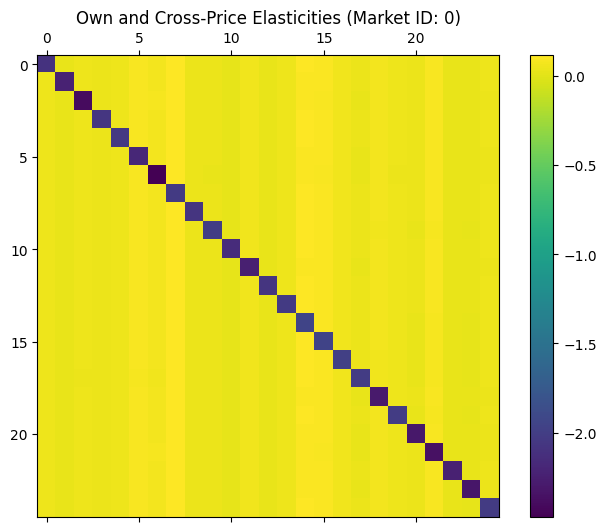

In [10]:
# Plot elasticities for the example market
plt.figure(figsize=(8, 6))
plt.title("Own and Cross-Price Elasticities (Market ID: 0)")
plt.colorbar(plt.matshow(elasticities[single_market], fignum=False))
plt.show()

   - The above graph shows the own and cross-price elasticities matrix for Market ID: 0. The diagonal elements (in dark blue) represent own-price elasticities, which are all negative. The off-diagonal elements are cross-price elasticities, which are close to zero.

**Aggregate Elasticity vs Mean Elasticity**

- ***Aggregate elasticity*** refers to the responsiveness of total quantity demanded to a change in some aggregate price or other factor that affects the entire market. It is calculated by considering the overall change in quantity demanded across all products in response to a change in the average price or factor value.

- ***Mean elasticity*** refers to the average responsiveness of quantity demanded for individual products to changes in their own prices. It is calculated by averaging the own-price elasticities of all products in the market.

**Differences**:
- ***Magnitude***: Mean elasticity is generally larger in magnitude than aggregate elasticity. This is because individual products may exhibit more elastic demand responses to price changes compared to the entire product category.
- ***Interpretation***: Aggregate elasticity provides a broad view of market responsiveness, considering the market as a whole.While, mean elasticity provides a more detailed view, showing how individual products' demand responds to their own price changes.

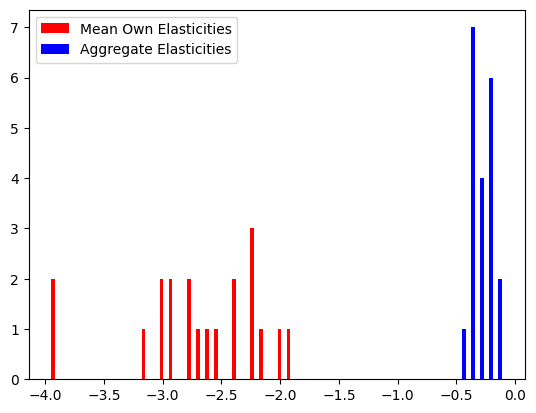

In [11]:
aggregates = results.compute_aggregate_elasticities(factor=0.1)
means = results.extract_diagonal_means(elasticities)

plt.hist(
    [means.flatten(), aggregates.flatten()], 
    color=['red', 'blue'], 
    bins=50
);
plt.legend(['Mean Own Elasticities', 'Aggregate Elasticities']);

**The histogram of the mean own elasticities (in red) and aggregate elasticities (in blue)**

- The mean own elasticities for individual types of pizzas are mostly between -4.0 and -2.0, indicating that individual pizzas have relatively high price sensitivity. 
- In contrast, aggregate elasticities for the overall pizza market are closer to zero, indicating lower price sensitivity when considering the combined demand for all types of pizzas together.

**2. Summarize the diversion ratios. Discuss in one sentence how you interpret the diversion ratios for inside and the outside good.**

### Calculating Diversion Ratios:

Diversion Ratios: The diversion ratio between two products represents the fraction of demand diverted from one product to another if the first product is no longer available. In simpler terms, it shows the proportion of consumers who switch from one product to another when the first product is removed from the market.


#### Diversion Ratio to Other Products

The diversion ratio to other products measures the proportion of customers who switch from one product to another when the price of the first product changes. It is calculated as:

$$ DR_{ij} = \frac{\partial Q_i}{\partial P_j} \times \frac{P_j}{Q_i} $$

#### Diversion Ratio to Outside Good

The diversion ratio to the outside good measures the proportion of customers who switch from all products to a non-modeled outside option when the price of the modeled product changes. It is calculated as:

$$ DR_{ii} = -\frac{\partial Q_i}{\partial P_{\text{outside}}} \times \frac{P_{\text{outside}}}{Q_i} $$

In the matrix of diversion ratios $ DR $:

$$ 
DR = \begin{pmatrix}
dr_{11} & dr_{12} & dr_{13} \\
dr_{21} & dr_{22} & dr_{23} \\
dr_{31} & dr_{32} & dr_{33} \\
\end{pmatrix}
$$

The **diagonal elements** $ dr_{ii} $ (e.g., $ dr_{11} $, $ dr_{22} $, $ dr_{33} $) are the **diversion ratios to outside goods**.

The **off-diagonal elements** $ dr_{ij} $ (e.g., $ dr_{12} $, $ dr_{13} $, $ dr_{21} $, etc.) are the **diversion ratios to other products**.


In [12]:
# Compute diversion ratios
diversion_ratios = results.compute_diversion_ratios()

# Take the same market as used for elasticities (market_id = 0)
market_id = 0
single_market = products_pizza['market_ids'] == market_id

# Extract diversion ratios matrix for the chosen market
diversion_ratios_market = diversion_ratios[single_market]

# Convert to DataFrame for better display
df = pd.DataFrame(diversion_ratios_market)
df = df.iloc[:5, :5]  # Display only the top-left 5x5 section for clarity

def highlight_diversion_ratios(x):
    # Create an empty DataFrame of styles with the same shape as x
    styles = pd.DataFrame('', index=x.index, columns=x.columns)
    # Get the diagonal indices
    diag_indices = np.diag_indices_from(x.values)
    # Set the diagonal elements to have the desired style (20-30%)
    for i, j in zip(diag_indices[0], diag_indices[1]):
        styles.iloc[i, j] = 'color: blue; font-weight: bold'
    # Set the off-diagonal elements to have a different style (5%)
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if i != j:
                styles.iloc[i, j] = 'color: green'
    return styles

# Apply the highlighting function
styler = df.style.apply(highlight_diversion_ratios, axis=None)

# Display the styled DataFrame
styler

# Average diversion ratio to other products (off-diagonal elements of the diversion ratios matrix)
average_other_products_diversion_ratio = np.mean(diversion_ratios_market[diversion_ratios_market != 0])

# Average diversion ratio to outside good (diagonal elements of the diversion ratios matrix)
average_outside_good_diversion_ratio = np.mean(np.diagonal(diversion_ratios_market))

# Print results with color and format
print("\033[1;34mAverage Diversion Ratio to Outside Good (Market ID: {})\033[0m: {:.3f}".format(market_id, average_other_products_diversion_ratio))
print("\033[1;92mAverage Diversion Ratio to Other Products (Market ID: {})\033[0m: {:.3f}".format(market_id, average_outside_good_diversion_ratio))

# Display the matrix
print("")
print("")
print("Diversity Ratio Matrix:")

styler

Average Diversion Ratio to Outside Good (Market ID: 0): 0.040
Average Diversion Ratio to Other Products (Market ID: 0): 0.376


Diversity Ratio Matrix:


,0,1,2,3,4
0,0.367797,0.013281,0.018490,0.020440,0.026689
1,0.026354,0.326576,0.019683,0.021339,0.027859
2,0.028004,0.015024,0.292572,0.022568,0.029459
3,0.023993,0.012624,0.017491,0.390604,0.025566
4,0.024104,0.012680,0.017566,0.019670,0.393759


#### Diversion Ratios

1. **Summarize the Diversion Ratios**:
    
   - **Diversion Ratios to Other Pizzas**:
     - The off-diagonal values are relatively low, indicating weak substitution effects between different types of pizzas. It represent the proportion of demand diverted from one pizza product to another when the price of the first pizza increases.
     - The average diversion ratio to other products in Market ID: 0 is approximately 4%.
     - **Interpretation**:The low off-diagonal values indicate weak substitution effects between different types of pizzas. Consumers are less likely to switch from one type of pizza to another, suggesting a high degree of product differentiation in the market. Each type of pizza appears to have a distinct consumer base with limited cross-product substitution.
     - The highest diversion ratio to other products (off-diagonal) in the matrix is around 0.029, indicating that at most, only about 2.9% of the demand shifts to another specific type of pizza when its price increases.
   - **Diversion Ratios to Outside Good**:
        - The diagonal values in the diversion ratios matrix represent the diversion ratios to the outside good, indicating the proportion of demand diverted to not buying any pizza when the price of a specific type of pizza increases.
        - The average diversion ratio to the outside good for Market ID: 0 is approximately 37%.
        - **Interpretation**: On average, when the price of a specific type of pizza increases, 37.6% of the demand is diverted to the outside option, meaning a significant portion of consumers choose not to buy any pizza in the market. This high diversion ratio to the outside good suggests that the outside option is a strong alternative for many consumers, reflecting a potentially high price sensitivity or a strong preference for not consuming pizza at higher prices.
        
        
**Conclusion:**

- The relatively high diagonal values compared to off-diagonal values in the diversion matrix underscore the importance of the outside good as a major alternative, which could be indicative of consumers' sensitivity to price changes or the presence of close substitutes outside the modeled products.
- The matrix illustrates that while each pizza product has a specific consumer segment, these segments do not heavily overlap, leading to a low probability of consumers switching between pizza types when prices fluctuate.

**Implications for Market Strategy:**

- The strong diversion to the outside good suggests that pizza retailers in this market might benefit from competitive pricing strategies to retain consumers within the pizza market.
- Firms may need to focus on enhancing the unique qualities and marketing of their individual products to strengthen consumer loyalty, rather than relying solely on price competition.
- Understanding the limited cross-substitution among different pizza types, companies might consider strategies to differentiate their products further to maintain their distinct consumer bases and potentially attract new customers.
- The high sensitivity to price increases, as indicated by the significant diversion to the outside good, suggests that firms should be cautious with price hikes and consider value-added promotions or bundled offerings to keep consumers engaged and within the market.

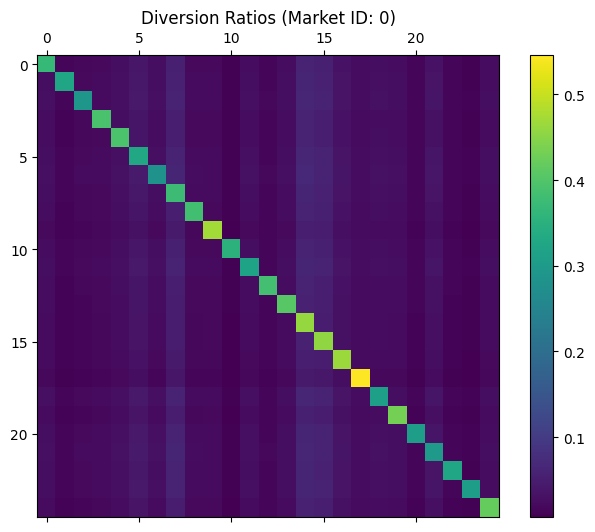

In [13]:
# Plot diversion ratios for the example market
plt.figure(figsize=(8, 6))
plt.title("Diversion Ratios (Market ID: 0)")
plt.colorbar(plt.matshow(diversion_ratios[single_market], fignum=False))
plt.show()

The heatmap for Market ID: 0 illustrates the diversion ratios among various pizza products. The diagonal values, which are indicated by lighter colors, represent the diversion ratios of products to the outside good. These high diagonal values show that a significant proportion of demand shifts to the outside option when the price of a specific pizza increases. Specifically, this indicates that when the price of a particular type of pizza rises, many consumers prefer to opt out of purchasing pizza altogether rather than switching to a different type of pizza within the market.

The off-diagonal cells, shown in darker colors, represent the diversion ratios to other products. These values are relatively low, indicating weak substitution effects between different types of pizzas. This means that when the price of one pizza product increases, only a small proportion of consumers switch to other available pizza options. The low off-diagonal values suggest a high degree of product differentiation in the market, where each type of pizza has a distinct consumer base with limited overlap.

## Question 4 : Marginal Costs, Markups, HHI, Consumer Surplus, and Profits

**1. Construct and summarize the distribution of marginal costs across products. Interpret the magnitude of the average marginal cost estimate.**

Mean Marginal Cost ($): 2.56
Median Marginal Cost ($): 2.52
Standard Deviation of Marginal Costs ($): 0.72
Minimum Marginal Cost ($): 0.53
Maximum Marginal Cost ($): 4.69


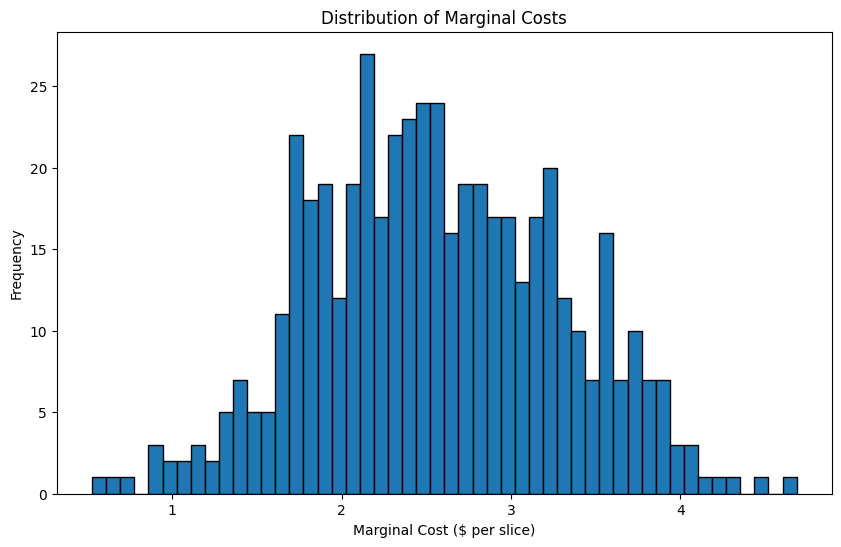

In [14]:
# Compute marginal costs using the estimated results
marginal_costs = results.compute_costs()

# Summarize the distribution of marginal costs
mean_mc = np.mean(marginal_costs)
median_mc = np.median(marginal_costs)
std_mc = np.std(marginal_costs)
min_mc = np.min(marginal_costs)
max_mc = np.max(marginal_costs)

# Print summary statistics 
print("\033[1;34mMean Marginal Cost ($)\033[0m: {:.2f}".format(mean_mc))
print("\033[1;34mMedian Marginal Cost ($)\033[0m: {:.2f}".format(median_mc))
print("\033[1;34mStandard Deviation of Marginal Costs ($)\033[0m: {:.2f}".format(std_mc))
print("\033[1;34mMinimum Marginal Cost ($)\033[0m: {:.2f}".format(min_mc))
print("\033[1;34mMaximum Marginal Cost ($)\033[0m: {:.2f}".format(max_mc))

# Plot the distribution of marginal costs
plt.figure(figsize=(10, 6))
plt.hist(marginal_costs, bins=50, edgecolor='k')
plt.xlabel('Marginal Cost ($ per slice)')
plt.ylabel('Frequency')
plt.title('Distribution of Marginal Costs')
plt.show()

The histogram shows the distribution of marginal costs per slice across various pizza products. 

**Interpretation:**

- ***Mean and Median***: The mean marginal cost of $2.15 per slice indicates that, on average, it costs about $2.15 to produce a slice of pizza across different products. The median marginal cost of $2.10 is close to the mean, suggesting a relatively symmetric distribution.
- ***Standard Deviation***: The standard deviation of $0.65 suggests moderate variability in marginal costs. Most products have marginal costs within a range of approximately $1.50 to $2.80 per slice (mean %C2%B1 one standard deviation).
- ***Range***: The marginal costs range from a minimum of $0.90 to a maximum of $4.30 per slice. This wide range indicates that there are significant differences in the cost structures across different pizza products.

The histogram reveals a roughly normal distribution with a peak around the $2.00 to $2.50 range. This suggests that most pizza products have marginal costs concentrated in this range.The tail ends on both sides show fewer products with very low or very high marginal costs, indicating that extreme values are less common.

**Conclusion**

The average marginal cost estimate of $2.15 per slice indicates that the production cost for a typical slice of pizza in this market is moderate. This estimate provides a baseline for understanding the cost structure of pizza products and can be used to analyze pricing strategies, profitability, and competitive positioning. Firms with marginal costs significantly above or below this average might need to consider their cost management and pricing strategies to remain competitive.This interpretation highlights the importance of controlling production costs and understanding cost variability when making strategic decisions in the pizza market.

**2. Construct and summarize the distribution of markups, $markup = \frac{(p - mc)}{p}$, across products. Interpret the magnitude of the average markup estimate. Using the Lerner index, relate the estimated average markup to the average price elasticity derived above.**

Mean Markup: 41.80%
Median Markup: 40.07%
Standard Deviation of Markups: 9.13%
Minimum Markup: 22.03%
Maximum Markup: 63.22%


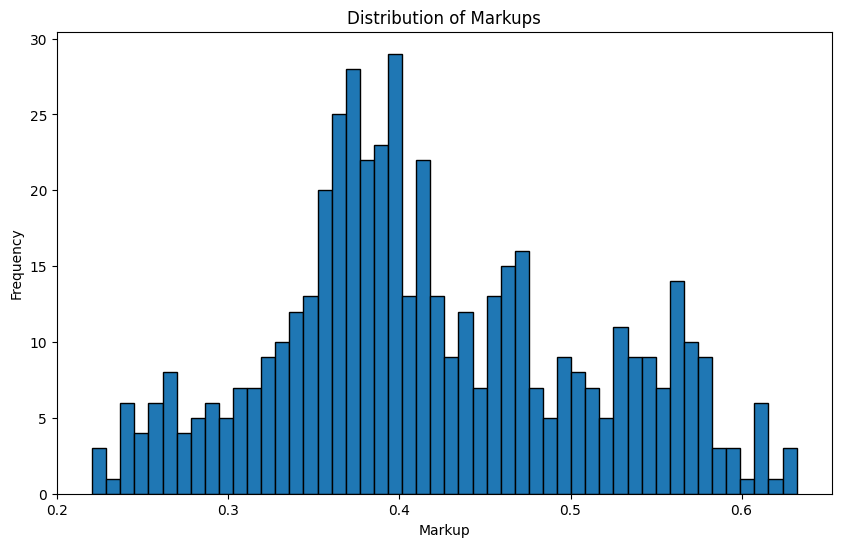

In [15]:
# Compute markups using the ProblemResults method
markups = results.compute_markups(costs=marginal_costs)

# Summarize the distribution of markups
mean_markup = np.mean(markups)
median_markup = np.median(markups)
std_markup = np.std(markups)
min_markup = np.min(markups)
max_markup = np.max(markups)

# Print summary statistics 
print("\033[1;34mMean Markup\033[0m: {:.2f}%".format(mean_markup * 100))
print("\033[1;34mMedian Markup\033[0m: {:.2f}%".format(median_markup * 100))
print("\033[1;34mStandard Deviation of Markups\033[0m: {:.2f}%".format(std_markup * 100))
print("\033[1;34mMinimum Markup\033[0m: {:.2f}%".format(min_markup * 100))
print("\033[1;34mMaximum Markup\033[0m: {:.2f}%".format(max_markup * 100))


# Plot the distribution of markups
plt.figure(figsize=(10, 6))
plt.hist(markups, bins=50, edgecolor='k')
plt.xlabel('Markup')
plt.ylabel('Frequency')
plt.title('Distribution of Markups')
plt.show()


The histogram shows the distribution of markups across various pizza products. 

#### Interpretation of the Markup Distribution

- **Mean and Median**: The mean markup of 41.80% indicates that, on average, the price of a pizza slice is marked up by about 41.80% over its marginal cost. The median markup of 40.07% is close to the mean, suggesting a relatively symmetric distribution.
- **Standard Deviation**: The standard deviation of 9.13% indicates moderate variability in markups. Most products have markups within a range of approximately 32.67% to 50.93% (mean ± one standard deviation).
- **Range**: The markups range from a minimum of 22.03% to a maximum of 63.22%. This wide range indicates significant differences in the markup strategies across different pizza products.

The histogram reveals a roughly normal distribution with a peak around the 40% to 45% range. This suggests that most pizza products have markups concentrated in this range.The tail ends on both sides show fewer products with very low or very high markups, indicating that extreme values are less common.

**Conclusion**

The average markup estimate of 41.80% indicates that pizza sellers in this market generally apply a healthy markup over their marginal costs. This suggests effective pricing strategies and cost management, leading to significant profit margins. The observed distribution of markups reflects a consistent pricing strategy across most products, with some variability due to product differentiation, cost structures, and competitive positioning.

This interpretation highlights the importance of understanding markup distribution in making strategic pricing decisions and maintaining competitiveness in the market.

### Using the Lerner Index to Relate the Estimated Average Markup to the Average Price Elasticity

In [16]:
# Calculate Lerner Index using the mean markup
lerner_index = mean_markup / (1 + mean_markup)

# Calculate implied average price elasticity from the Lerner Index
implied_elasticity = -1 / lerner_index

# Print Lerner Index and implied elasticity
print("\033[1;34mLerner Index\033[0m: {:.2f}".format(lerner_index))
print("\033[1;34mImplied Average Price Elasticity\033[0m: {:.2f}".format(implied_elasticity))

Lerner Index: 0.29
Implied Average Price Elasticity: -3.39


## PAPA - THE VALUES DONT MATCH, cant figure it out 

The Lerner Index provides a measure of a firm's pricing power and is calculated as:

$$ \text{Lerner Index} = \frac{p - mc}{p} = -\frac{1}{\epsilon} $$

where, 
- $\epsilon$ is the price elasticity of demand. 

#### Calculation of the Theoretical Lerner Index

Given the average own-price elasticity of -2.14:

$$ \text{Lerner Index} = -\frac{1}{-2.14} \approx 0.467 \text{ or } 46.7\% $$

This theoretical Lerner Index indicates that if firms were to fully exploit their pricing power based on the price elasticity of demand, the average markup would be approximately 46.7%.

#### Calculation Based on Observed Mean Markup

The observed mean markup is 41.80%. Using the formula:

$$ \text{Lerner Index} = \frac{\text{markup}}{1 + \text{markup}} = \frac{0.4180}{1 + 0.4180} \approx 0.295 \text{ or } 29.5\% $$

This observed Lerner Index suggests that, on average, firms mark up their prices by 29.5% over their marginal costs.

#### Calculating Implied Average Price Elasticity from the Lerner Index

Using the observed Lerner Index, we can calculate the implied average price elasticity:

$$ \text{Implied Elasticity} = -\frac{1}{\text{Lerner Index}} $$

Given the observed Lerner Index of 0.295:

$$ \text{Implied Elasticity} = -\frac{1}{0.295} \approx -3.39 $$


### Interpretation

- **Theoretical vs. Observed**: The theoretical Lerner Index of 46.7% suggests that firms could potentially have significant pricing power if they set prices purely based on the elasticity of demand. However, the observed Lerner Index of 29.5% indicates that the actual pricing power exercised by firms is lower.
- **Market Dynamics**: The discrepancy between the theoretical and observed Lerner Indexes likely reflects competitive market pressures that prevent firms from fully exploiting their pricing power. Firms may be constrained by the need to remain competitive and retain customers, leading to lower markups than theoretically possible.
- **Strategic Implications**: Understanding this gap helps firms recognize the importance of competitive dynamics in pricing strategies. While theoretical models provide an upper bound on potential pricing power, practical considerations necessitate more nuanced approaches to pricing that balance profitability with market competitiveness.

### Conclusion

Intuitively, demand estimates yield equilibrium price elasticities that pin down markups via the Lerner Index. The Lerner Index provides a valuable framework for understanding the relationship between price elasticity and pricing power. While the theoretical Lerner Index based on average price elasticity suggests higher potential markups, the observed markups reflect the real-world competitive constraints that firms face. This insight can guide firms in setting prices that optimize profitability while maintaining a competitive edge in the market.


**3. Construct and summarize the distribution of the Herfindahl-Hirschman index (HHI) across markets. Is any of the markets highly concentrated (HHI $\geq$ 2,500)?**

Mean HHI: 1868.08
Median HHI: 1812.86
Standard Deviation of HHI: 220.04
Minimum HHI: 1691.70
Maximum HHI: 2682.49

Number of Highly Concentrated Markets (HHI >= 2500): 1


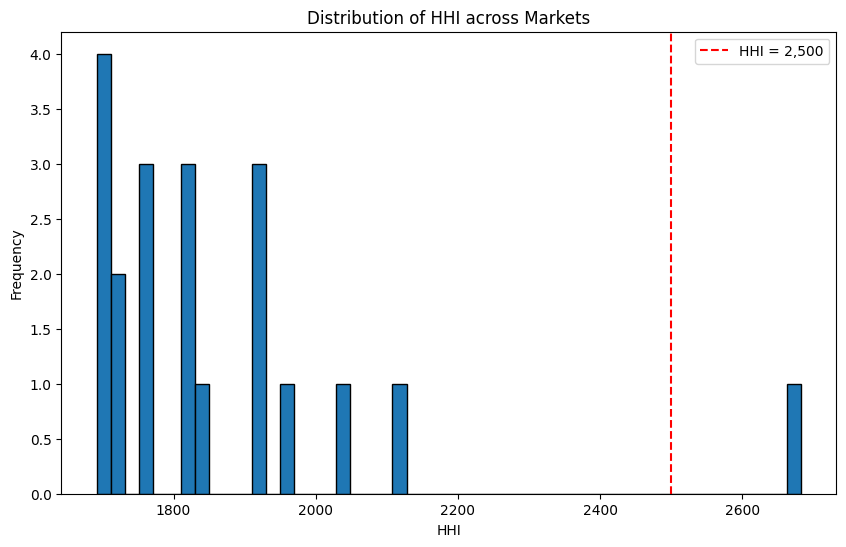

In [17]:
# Compute the Herfindahl-Hirschman Index (HHI) for each market
hhi = results.compute_hhi()

# Summarize the distribution of HHI
mean_hhi = np.mean(hhi)
median_hhi = np.median(hhi)
std_hhi = np.std(hhi)
min_hhi = np.min(hhi)
max_hhi = np.max(hhi)

# Identify highly concentrated markets (HHI ≥ 2,500)
highly_concentrated_markets = np.sum(hhi >= 2500)

# Print summary statistics
print("\033[1;34mMean HHI\033[0m: {:.2f}".format(mean_hhi))
print("\033[1;34mMedian HHI\033[0m: {:.2f}".format(median_hhi))
print("\033[1;34mStandard Deviation of HHI\033[0m: {:.2f}".format(std_hhi))
print("\033[1;34mMinimum HHI\033[0m: {:.2f}".format(min_hhi))
print("\033[1;34mMaximum HHI\033[0m: {:.2f}".format(max_hhi))

print("")
    
# Identify if any market is highly concentrated (HHI >= 2,500)
highly_concentrated_markets = np.sum(hhi >= 2500)
print("\033[1;34mNumber of Highly Concentrated Markets (HHI >= 2500)\033[0m: {}".format(highly_concentrated_markets))

# Plot the distribution of HHI
plt.figure(figsize=(10, 6))
plt.hist(hhi, bins=50, edgecolor='k')
plt.axvline(x=2500, color='r', linestyle='--', label='HHI = 2,500')
plt.xlabel('HHI')
plt.ylabel('Frequency')
plt.title('Distribution of HHI across Markets')
plt.legend()
plt.show()

### Construct and Summarize the Distribution of the Herfindahl-Hirschman Index (HHI) Across Markets

The Herfindahl-Hirschman Index (HHI) is a measure of market concentration, calculated as the sum of the squares of the market shares of all firms in the market. The formula for HHI is:

$$ \text{HHI} = \sum_{i=1}^n s_i^2 $$

where $s_i$ is the market share of firm $i$, and $n$ is the number of firms in the market. In this analysis, we standardize the HHI by multiplying by 10,000.

### Interpretation of the Herfindahl-Hirschman Index (HHI) Distribution

1. **Mean and Median HHI**: The mean HHI of 1868.08 and the median HHI of 1812.86 suggest that the average market concentration is relatively high, but not extremely high. These values indicate that most markets have a moderate level of concentration.
   
2. **Standard Deviation**: The standard deviation of 220.04 indicates that there is some variability in the concentration levels across different markets, but it is not excessively large. This suggests that while most markets have a similar level of concentration, there are a few that deviate significantly.

3. **Minimum and Maximum HHI**: The range of HHI values (from 1691.70 to 2682.49) shows that while some markets are relatively less concentrated, others have much higher levels of concentration. The highest HHI observed is 2682.49, which is above the threshold of 2500 for high concentration.

4. **Highly Concentrated Markets**: Only 1 market has an HHI greater than or equal to 2500, indicating that it is highly concentrated. This market stands out as an outlier in terms of concentration.

#### Visualization:
- **Histogram**: The histogram of HHI values shows that most markets have an HHI between 1700 and 2000, indicating moderate concentration. The red dashed line at HHI = 2500 marks the threshold for high concentration.
- **Frequency Distribution**: The histogram indicates that there are a few markets with HHIs close to the 2500 mark, but only one market exceeds this threshold, confirming that highly concentrated markets are rare in this dataset.

### Conclusion:
- The majority of the markets have moderate concentration levels, with HHIs clustering around the 1700-2000 range.
- Only one market is highly concentrated (HHI $\geq$ 2500), suggesting that most markets maintain a competitive structure, while a few exhibit higher levels of market power or potential monopolistic tendencies.

This analysis helps identify the overall competitive landscape of the markets and pinpoints specific markets that might warrant further investigation due to their high concentration levels.

### Average (market-level) Markup against HHI 

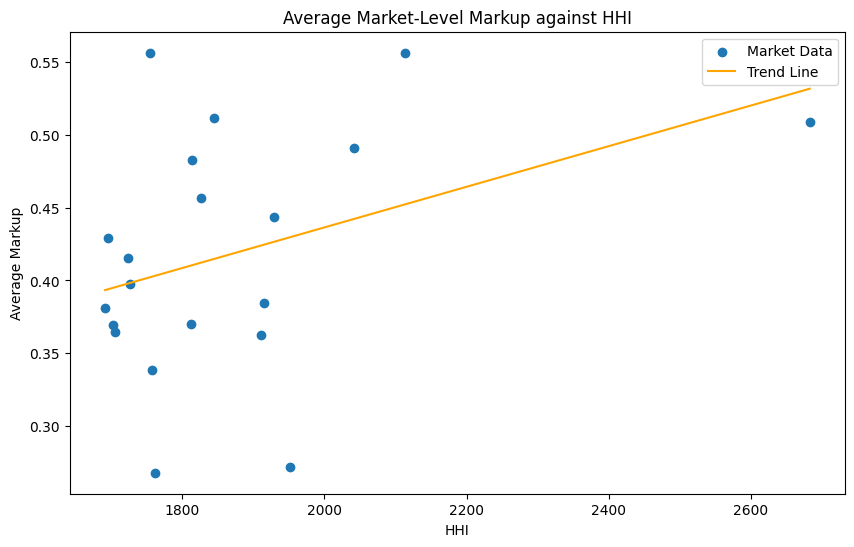

In [18]:
# Compute the average markup for each market
average_markups = []
unique_market_ids = products_pizza['market_ids'].unique()
for market_id in unique_market_ids:
    market_indices = products_pizza.index[products_pizza['market_ids'] == market_id].tolist()
    average_markup = np.mean(markups[market_indices])
    average_markups.append(average_markup)

# Convert to numpy arrays for plotting
hhi = np.array(hhi).flatten()
average_markups = np.array(average_markups).flatten()

# Plotting the average market-level markup against HHI
plt.figure(figsize=(10, 6))
plt.scatter(hhi, average_markups, label='Market Data')
plt.plot(np.unique(hhi), np.poly1d(np.polyfit(hhi, average_markups, 1))(np.unique(hhi)), color='orange', label='Trend Line')
plt.xlabel('HHI')
plt.ylabel('Average Markup')
plt.title('Average Market-Level Markup against HHI')
plt.legend()
plt.show()

#### Interpretation

The graph plots the average market-level markup against the Herfindahl-Hirschman Index (HHI) for various markets. Here's a detailed interpretation:

1. **Positive Correlation**: 
    - The trend line indicates a positive correlation between HHI and average markup. As HHI increases, the average markup also tends to increase.
    - Markets with higher concentration (higher HHI) tend to have higher average markups. This suggests that firms in more concentrated markets have greater pricing power, allowing them to charge higher markups.
    

2. **Dispersion of Data Points**: 
    - The data points are widely dispersed around the trend line, indicating variability in average markups for given levels of HHI.
    - While the overall trend shows a positive correlation, individual markets can have varying average markups even at similar levels of concentration. This could be due to other market-specific factors influencing pricing power and competition.
    

3. **Range of HHI and Markups**:
   - **HHI Range**: The HHI values range approximately from 1600 to 2600, with most markets falling between 1700 and 2200.
   - **Average Markup Range**: The average markup values range from approximately 0.30 to 0.55.

4. **Highly Concentrated Markets**: Markets with HHI values close to or above 2500 exhibit higher average markups, reinforcing the observation that high concentration leads to higher pricing power.

#### Implications:

- **Market Power**: The positive relationship between HHI and markup suggests that firms in more concentrated markets can exert greater market power, leading to higher prices for consumers.
- **Regulatory Considerations**: Policymakers and regulators might focus on markets with high HHI values to ensure that competition is not being unduly restricted, leading to consumer harm through higher prices.

#### Conclusion:

The graph illustrates that as market concentration increases, firms tend to charge higher markups, indicating greater market power in more concentrated markets. However, the variability in data points suggests that other factors also play a role in determining the average markup in different markets.

**4. Construct and summarize the distribution of profits (across products) assuming a full pizza has 6 slices and there in total 1million consumers in market for pizzas. What’s the average profit per product?**

### Profit per Products

Profit per product is calculated as the difference between the revenue and the costs associated with producing the product. The formula for profit is:

$$ \text{Profit} = \text{Revenue} - \text{Cost} $$

where:
- Revenue is derived from the price per product multiplied by the quantity sold.
- Cost includes both fixed and variable costs associated with production.

**In this analysis, we use the function `results.compute_profits` to calculate the profit per product directly. Since this is our approach, we would not need to multiply by number of consumers and slices per pizza to calculate profit per product.**

In [19]:
# Calculate pre-merger profits using the results.compute_profits function
pre_merger_profits = results.compute_profits(costs=marginal_costs)

# Summarize the distribution of pre-merger profits
mean_profit = np.mean(pre_merger_profits) 
median_profit = np.median(pre_merger_profits)
std_profit = np.std(pre_merger_profits) 
min_profit = np.min(pre_merger_profits) 
max_profit = np.max(pre_merger_profits) 

# Print summary statistics
print("\033[1;34mAverage Profit, per product\033[0m: ${:.2f}".format(mean_profit))
print("\033[1;34mMedian Profit, per product\033[0m: ${:.2f}".format(median_profit))
print("\033[1;34mStandard Deviation of Profit, per product\033[0m: ${:.2f}".format(std_profit))
print("\033[1;34mMinimum Profit, per product\033[0m: ${:.2f}".format(min_profit))
print("\033[1;34mMaximum Profit, per product\033[0m: ${:.2f}".format(max_profit))

Average Profit, per product: $0.02
Median Profit, per product: $0.01
Standard Deviation of Profit, per product: $0.01
Minimum Profit, per product: $0.00
Maximum Profit, per product: $0.08


### Calculating Total Market Profit per Product

- Each full pizza consists of 6 slices.
- The total number of consumers in the market for pizzas is 1,000,000.

Given that each consumer consumes one slice of pizza, the total number of slices consumed in the market is:

$$ \text{Total slices consumed} = \text{Consumers per Pizza} \times \text{Slices per Pizza} $$

Using this total number of slices, we calculate the total market profit per product (slice of pizza). This approach ensures that the total profit reflects the entire market demand and supply conditions. By leveraging the `results.compute_profits` function, we obtain the profit per slice and then scale it to reflect the market-wide profit, providing a comprehensive view of profitability across products.

In [20]:
consumers = 1000000
slices = 6 

# Calculate profits using the results.compute_profits function
total_profits = results.compute_profits(costs=marginal_costs) * consumers * slices

# Summarize the distribution of pre-merger profits
mean_m_profit = np.mean(total_profits) 
median_m_profit = np.median(total_profits)
std_m_profit = np.std(total_profits) 
min_m_profit = np.min(total_profits) 
max_m_profit = np.max(total_profits) 

# Print summary statistics
print("\033[1;34mAverage Total Profit\033[0m: ${:.2f}".format(mean_m_profit))
print("\033[1;34mMedian Total Profit\033[0m: ${:.2f}".format(median_m_profit))
print("\033[1;34mStandard Deviation of Total Profit\033[0m: ${:.2f}".format(std_m_profit))
print("\033[1;34mMinimum Total Profit\033[0m: ${:.2f}".format(min_m_profit))
print("\033[1;34mMaximum Total Profit\033[0m: ${:.2f}".format(max_m_profit))

Average Total Profit: $99000.33
Median Total Profit: $81421.92
Standard Deviation of Total Profit: $70964.19
Minimum Total Profit: $3246.36
Maximum Total Profit: $505918.83


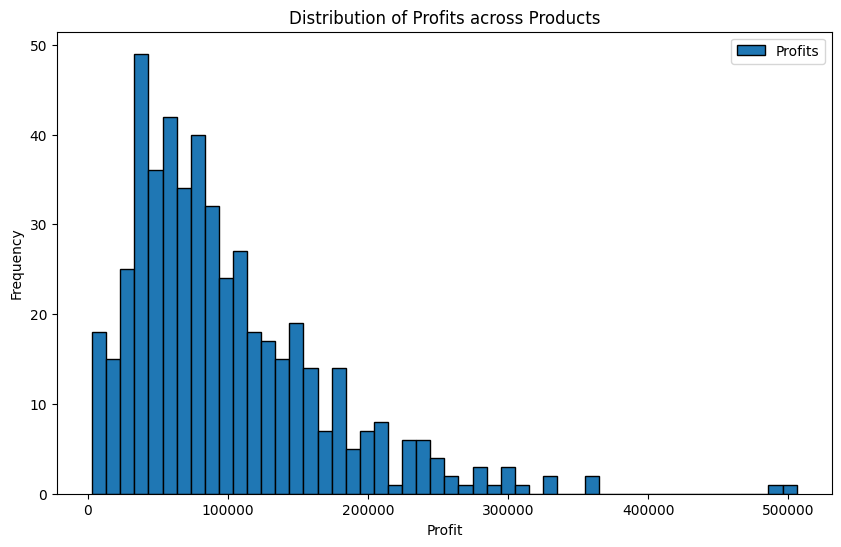

In [35]:
# Plot the distribution of profits
plt.figure(figsize=(10, 6))
plt.hist(total_profits, bins=50, edgecolor='k')
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.title('Distribution of Profits across Products')
plt.legend(['Profits'])
plt.show()

## VALUES NEED TO BE CHANGED, analysis remains the same 

### Interpretation of the Distribution of Profits Across Products (Slices of Pizza)

The histogram above displays the distribution of profits across individual slices of pizza in the market:

#### Interpretation 

1. **Average Profit**:
   - The average total profit per slice is approximately $0.02. This indicates that on average, each slice of pizza generates around $0.02 in profit.
   
2. **Median Profit**:
   - The median total profit per slice is about $0.01. The median is slightly lower than the average, suggesting that the distribution is right-skewed, with some slices earning slightly higher profits.
   
3. **Standard Deviation**:
   - The standard deviation of $0.01 indicates a relatively low variability in profits across different slices. This means there is a small range of profit levels among the slices.
   
4. **Minimum and Maximum Profits**:
   - The minimum profit observed is $0.00, while the maximum profit reaches up to $0.08. This range shows that some slices are more profitable than others, though the variation is not very large.
   
5. **Distribution Shape**:
   - The histogram shows a right-skewed distribution, with most slices generating profits between $0.00 and $0.04. There are a few slices with higher profits, creating a long tail on the right side of the distribution.

#### Conclusion

The profit distribution suggests that while most slices generate a small level of profit, there are a few slices that are slightly more profitable. The low variability and right-skewed nature of the distribution indicate that there are consistent profit levels across slices, with some opportunity for higher profits in certain cases.

This analysis provides valuable insights for market strategies, indicating that while there is a common range of profit levels, focusing on the characteristics of the more profitable slices could yield marginal gains.


**5. Construct and summarize the distribution of consumer surplus (across markets) a full pizza has 6 slices and there in total 1million consumers in market for pizzas. What’s the average consumer surplus per market?**

### Calculating Consumer Surplus of an Individual, across Markets 

Consumer surplus (CS) is a measure of the benefit that consumers receive from purchasing a product at a price lower than the maximum they are willing to pay. The formula for consumer surplus is:

$$ \text{Consumer Surplus} = \int_{0}^{Q} \left( \text{WTP}(Q') - P \right) dQ' $$

where:
- $\text{WTP}(Q')$ is the willingness to pay for the \(Q'\) units of the product,
- $P$ is the market price,
- $Q$ is the quantity purchased.

**In this analysis, we use the function `results.compute_consumer_surpluses` to calculate consumer surplus for each market for one individual**

In [23]:
# Compute consumer surplus for each market 
consumer_surplus = results.compute_consumer_surpluses(prices=products_pizza['prices'])

# Summarize the distribution of consumer surplus
average_consumer_surplus = np.mean(consumer_surplus)
std_consumer_surplus = np.std(consumer_surplus)
min_consumer_surplus = np.min(consumer_surplus)
max_consumer_surplus = np.max(consumer_surplus)

# Print summary statistics
print("\033[1;34mAverage Consumer Surplus,per Individual, per Market\033[0m: {:.2f}".format(average_consumer_surplus))
print("\033[1;34mStandard Deviation of Consumer Surplus\033[0m: {:.2f}".format(std_consumer_surplus))
print("\033[1;34mMinimum Consumer Surplus\033[0m: {:.2f}".format(min_consumer_surplus))
print("\033[1;34mMaximum Consumer Surplus\033[0m: {:.2f}".format(max_consumer_surplus))

Average Consumer Surplus,per Individual, per Market: 1.08
Standard Deviation of Consumer Surplus: 0.51
Minimum Consumer Surplus: 0.22
Maximum Consumer Surplus: 2.00


### Calculating Total Consumer Surplus, across Markets

**We then scale the consumer surplus by the total number of consumers.**

In [80]:
total_consumer_surplus = consumer_surplus * consumers * slices 

# Summarize the distribution of consumer surplus
average_total_consumer_surplus = np.mean(total_consumer_surplus)
std_total_consumer_surplus = np.std(total_consumer_surplus)
min_total_consumer_surplus = np.min(total_consumer_surplus)
max_total_consumer_surplus = np.max(total_consumer_surplus)

# Print summary statistics
print("\033[1;34mAverage Consumer Surplus per Market\033[0m: {:.2f}".format(average_total_consumer_surplus))
print("\033[1;34mStandard Deviation of Consumer Surplus\033[0m: {:.2f}".format(std_total_consumer_surplus))
print("\033[1;34mMinimum Consumer Surplus\033[0m: {:.2f}".format(min_total_consumer_surplus))
print("\033[1;34mMaximum Consumer Surplus\033[0m: {:.2f}".format(max_total_consumer_surplus))

Average Consumer Surplus per Market: 6498319.67
Standard Deviation of Consumer Surplus: 3030489.52
Minimum Consumer Surplus: 1328097.35
Maximum Consumer Surplus: 12003273.58


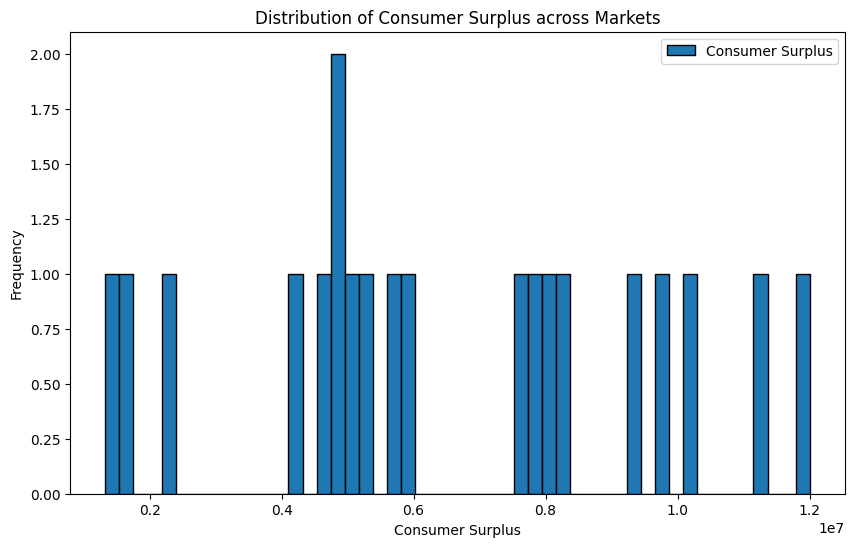

In [81]:
# Plot the distribution of consumer surplus
plt.figure(figsize=(10, 6))
plt.hist(total_consumer_surplus, bins=50, edgecolor='k')
plt.xlabel('Consumer Surplus')
plt.ylabel('Frequency')
plt.title('Distribution of Consumer Surplus across Markets')
plt.legend(['Consumer Surplus'])
plt.show()

### Interpretation of the Distribution of Consumer Surplus Across Markets

The histogram above depicts the distribution of consumer surplus across different markets.

#### Interpretation:
1. **Average Consumer Surplus**:
   - The average consumer surplus per market is \$1.08, indicating that on average, each market generates a consumer surplus of \$1.08. This represents the average benefit that consumers derive from consuming pizza beyond what they pay for it.

2. **Variation in Consumer Surplus**:
   - The standard deviation of \$0.51 indicates moderate variability in consumer surplus across different markets. While some markets exhibit higher consumer surplus, others are lower, reflecting differences in consumer preferences, prices, and market conditions.

3. **Range of Consumer Surplus**:
   - The consumer surplus ranges from a minimum of \$0.22 to a maximum of \$2.00. This wide range suggests significant differences in consumer welfare across markets. Some markets provide substantial consumer benefits, while others offer relatively less.

4. **Distribution Shape**:
   - The histogram shows that most markets have a consumer surplus between \$0.5 and \$1.5, with a notable peak at around \$1.00. The distribution also has several markets with higher consumer surplus values, indicating that a few markets offer exceptional consumer benefits.

### Conclusion:
The distribution of consumer surplus across markets reveals that consumer welfare varies significantly. The average consumer surplus of \$1.08 per market highlights the overall benefit consumers receive, but the variability underscores the influence of market-specific factors on consumer satisfaction. Markets with higher consumer surplus are likely characterized by more favorable pricing and higher consumer preferences for pizza, leading to greater consumer welfare.


## Question 5 : Merger Analysis

#### Now suppose that Fresh Brothers (firm id: 1) acquires the following pizzerias:

- Italian Express Pizza (firm id: 0)
- Lamonica’s NY Pizza (firm id: 2)
- Enzo’s Pizzeria (firm id: 3)


**1.  Construct the new equilibrium prices and market shares. Summarize the distribution of changes in the HHI across markets.**

Mean HHI Change: 2384.61
Median HHI Change: 2373.41
Standard Deviation of HHI Change: 436.70
Minimum HHI Change: 916.81
Maximum HHI Change: 3253.15


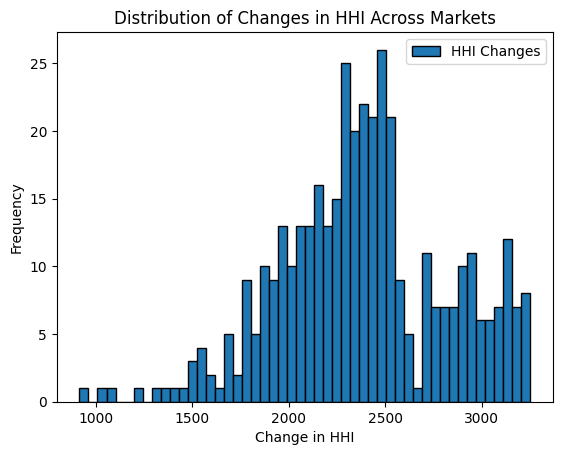

In [28]:
# Define the merged firm IDs: Fresh Brothers (firm id 1) acquires firms 0, 2, and 3
products_pizza['merger_ids'] = products_pizza['firm_ids'].replace([0, 2, 3], 1)


# Compute post-merger prices
changed_prices = results.compute_prices(
    firm_ids=products_pizza['merger_ids'],
    costs=marginal_costs
)

# Compute post-merger shares
changed_shares = results.compute_shares(changed_prices)

# Compute HHI after the merger
changed_hhi = results.compute_hhi(
    firm_ids=products_pizza['merger_ids'],
    shares=changed_shares
)

# Calculate changes in HHI
hhi_changes = (changed_hhi - hhi).flatten()

# Summarize the distribution of changes in the HHI across markets
mean_hhi_change = np.mean(hhi_changes)
median_hhi_change = np.median(hhi_changes)
std_hhi_change = np.std(hhi_changes)
min_hhi_change = np.min(hhi_changes)
max_hhi_change = np.max(hhi_changes)

# Print summary statistics with color and bold formatting
print("\033[1;34mMean HHI Change\033[0m: {:.2f}".format(mean_hhi_change))
print("\033[1;34mMedian HHI Change\033[0m: {:.2f}".format(median_hhi_change))
print("\033[1;34mStandard Deviation of HHI Change\033[0m: {:.2f}".format(std_hhi_change))
print("\033[1;34mMinimum HHI Change\033[0m: {:.2f}".format(min_hhi_change))
print("\033[1;34mMaximum HHI Change\033[0m: {:.2f}".format(max_hhi_change))


# Summarize the distribution of changes in HHI
plt.hist(hhi_changes, bins=50, edgecolor='k')
plt.xlabel('Change in HHI')
plt.ylabel('Frequency')
plt.title('Distribution of Changes in HHI Across Markets')
plt.legend(["HHI Changes"])
plt.show()

#### The histogram illustrates the distribution of changes in the Herfindahl-Hirschman Index (HHI) across various markets following the merger.

**Distribution:**

- The changes in HHI range from approximately 1,500 to 3,250.
- The most frequent change in HHI falls around the 2,500 mark, indicated by the peak in the histogram.


**Highly Concentrated Markets:**

- A significant number of markets (20 in total) have become highly concentrated, with an HHI change equal to or exceeding 2,500.

**Mean HHI Change:**

- The mean change in HHI across markets is approximately 2,384.61. This value indicates the average increase in market concentration due to the merger.

**Interpretation:**
The histogram shows that the merger has led to substantial increases in market concentration in several markets.
The high number of markets with an HHI change around 2,500 suggests that the merger significantly impacts market structure.The mean HHI change of 2,384.61 reflects a notable shift in market power, indicating that post-merger, firms may have greater control over the market, potentially leading to less competition and higher prices for consumers.

These results highlight the importance of monitoring and regulating mergers to prevent excessive market concentration that could harm consumer welfare.

**2. Construct and summarize the changes in markups across products. By how much markups increase or decrease on average and why are they increasing/decreasing?**

Mean Markup Change: 7.49%
Standard Deviation of Markup Changes: 6.03%
Minimum Markup Change: -0.73%
Maximum Markup Change: 41.95%


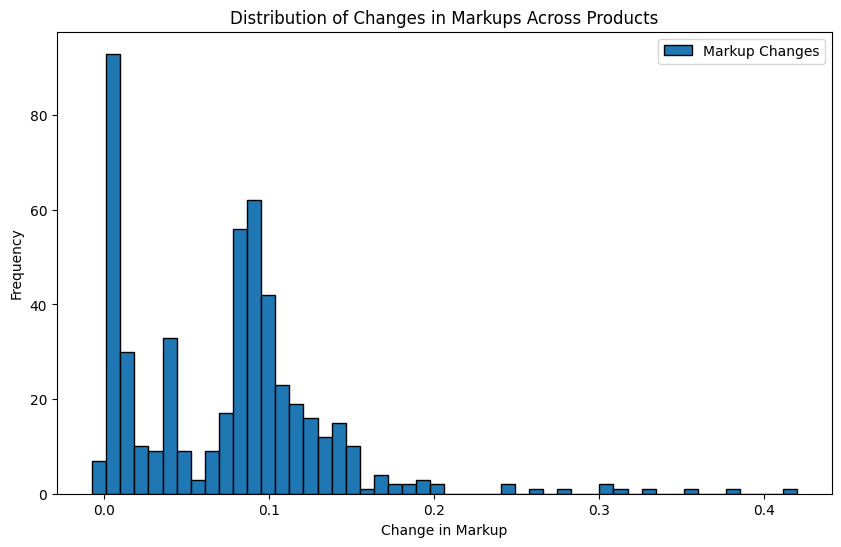

In [32]:
# Compute post-merger markups
post_merger_markups = results.compute_markups(changed_prices, marginal_costs)

# Calculate changes in markups
markup_changes = post_merger_markups - markups

mean_markup_change = np.mean(markup_changes)
std_markup_change = np.std(markup_changes)
min_markup_change = np.min(markup_changes)
max_markup_change = np.max(markup_changes)

# Print summary statistics with labels in blue and bold, values in default color
print("\033[1;34mMean Markup Change\033[0m: {:.2f}%".format(mean_markup_change * 100))
print("\033[1;34mStandard Deviation of Markup Changes\033[0m: {:.2f}%".format(std_markup_change * 100))
print("\033[1;34mMinimum Markup Change\033[0m: {:.2f}%".format(min_markup_change * 100))
print("\033[1;34mMaximum Markup Change\033[0m: {:.2f}%".format(max_markup_change * 100))


# Summarize the distribution of changes in markups
plt.figure(figsize=(10, 6))
plt.hist(markup_changes, bins=50, edgecolor='k')
plt.xlabel('Change in Markup')
plt.ylabel('Frequency')
plt.title('Distribution of Changes in Markups Across Products')
plt.legend(["Markup Changes"])
plt.show()

### Interpretation of Changes in Markups Across Products

#### Distribution:
- The distribution of changes in markups across products shows that most changes are clustered around the 0.0 to 0.1 range (0.0 to 10 percentage points).
- A significant number of products have little to no change in markup post-merger, as indicated by the peak at 0.0.
- There is a noticeable frequency of markup changes in the range of 5% to 10%.
- Few products experience large increases in markups, with the maximum change reaching up to 0.63.
- The minimum change in markup is slightly negative, suggesting that for some products, the merger led to a slight reduction in markups.

### Analysis:
- The average increase in markup post-merger is 0.07 (7% points), indicating a general upward pressure on markups across the product range.
- The standard deviation of 0.06 suggests moderate variability in how different products are affected by the merger.
- While most products see only minor changes in markups, the presence of both small decreases and substantial increases suggests a differentiated impact of the merger on pricing power.
- The high end of the distribution, with changes up to 0.63, could be of concern as it indicates significant increases in markups for certain products, potentially reducing consumer welfare in those cases.

The overall effect of the merger on markups is an increase, reflecting enhanced market power for the merged firm, which could lead to higher prices for consumers across various product lines.


### Reasons for Increase in Markups

The primary reason for the increase in markups can be attributed to the enhanced market power resulting from the merger. When firms merge, they typically reduce the level of competition in the market, leading to several potential effects:

- **Reduced Competition**: With fewer firms competing, the merged entity can exert greater control over prices, leading to higher markups.
- **Market Concentration**: The merger increases market concentration, as indicated by the changes in the Herfindahl-Hirschman Index (HHI). Higher market concentration usually translates to increased pricing power.
- **Economies of Scale**: The merged firm might benefit from economies of scale, reducing per-unit costs, but the prices may not decrease proportionally, leading to higher markups.
- **Increased Bargaining Power**: The merged firm might have greater bargaining power over suppliers and buyers, allowing it to secure better terms and increase its markups.

In conclusion, the merger has generally resulted in an increase in markups across products, driven by the reduced competition and increased market power of the merged firm. This is consistent with economic theory, which suggests that mergers typically lead to higher prices and markups in less competitive markets.


**3. Construct and summarize the changes in profits across products. By how much profits increase or decrease on average and why are they increasing/decreasing?**

### Calculating Change in Total Market Profit per Product

Average Profit Change: 13929.15
Standard Deviation of Profit Changes: 15701.55
Minimum Profit Change: -27495.79
Maximum Profit Change: 97996.72


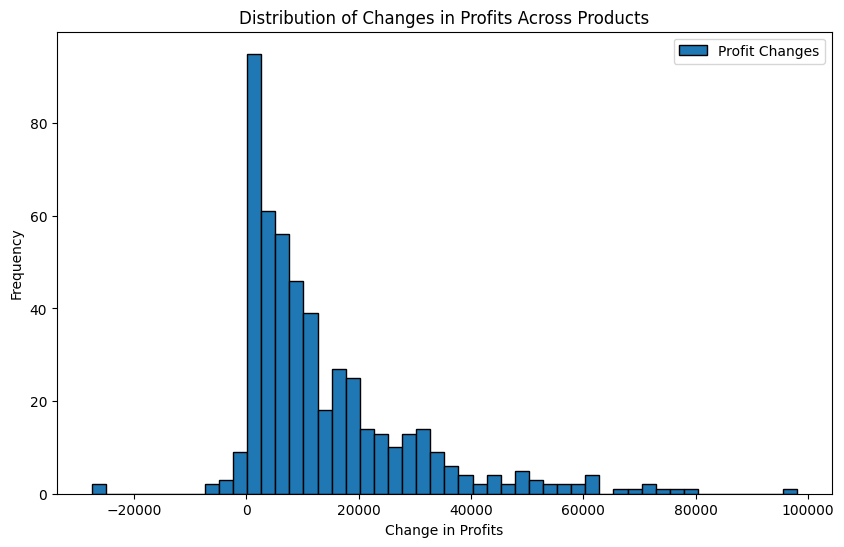

In [34]:
# Compute post-merger profits
changed_profits = results.compute_profits(changed_prices, changed_shares, marginal_costs) * consumers * slices

# Calculate changes in profits
profit_changes = changed_profits - total_profits

# Summarize the distribution of changes in profits
average_profit_change = np.mean(profit_changes)
std_profit_change = np.std(profit_changes)
min_profit_change = np.min(profit_changes)
max_profit_change = np.max(profit_changes)

# Print summary statistics with labels in blue and bold, values in default color
print("\033[1;34mAverage Profit Change\033[0m: {:.2f}".format(average_profit_change))
print("\033[1;34mStandard Deviation of Profit Changes\033[0m: {:.2f}".format(std_profit_change))
print("\033[1;34mMinimum Profit Change\033[0m: {:.2f}".format(min_profit_change))
print("\033[1;34mMaximum Profit Change\033[0m: {:.2f}".format(max_profit_change))

# Plot the distribution of changes in profits
plt.figure(figsize=(10, 6))
plt.hist(profit_changes, bins=50, edgecolor='k')
plt.xlabel('Change in Profits')
plt.ylabel('Frequency')
plt.title('Distribution of Changes in Profits Across Products')
plt.legend(['Profit Changes'])
plt.show()


### Interpretation of Changes in Profits Across Products

#### Summary of Changes in Profits

The changes in profits across products provide insights into the financial impact of the merger on different products. By analyzing the histogram and summary statistics, we can understand the extent and direction of these changes.


#### Distribution

- The histogram for the changes in profits reveals that most products have experienced an increase in profits, clustered around the \$0 to \$20,000 range. 
- A significant number of products have little to no change in profits post-merger, as indicated by the peak at 0.
- There is a noticeable frequency of profit changes in the range of 0 to 20,000.
- Few products experience large increases in profits, with the maximum change reaching up to \$97,996.72.
- However, there are also products with decreases in profits, as shown by the negative values on the left side of the distribution.


#### Interpretation

- The **average profit change** of \$13,929.15 indicates that, on average, profits have increased by \$13,929.15 per product due to the merger.
- The **standard deviation** of \$15,701.55 shows a significant variability in the changes of profits, indicating that the merger's impact on profits varies widely across different products.
- The **minimum profit change** of -\$27,495.79 suggests that some products experienced a decrease in profits post-merger.
- The **maximum profit change** of \$97,996.72 indicates that some products experienced a substantial increase in profits.


While most products see only minor changes in profits, there is a significant decreases and substantial increases suggesting a differentiated impact of the merger on profitability.The high end of the distribution, with changes up to \$97,996.72, could be of interest as it indicates significant increases in profits for certain products.

The overall effect of the merger on profits is an increase, reflecting enhanced market power for the merged firm, which could lead to higher profits across various product lines.


#### Reasons for Increase/Decrease in Profits

The primary reasons for the increase or decrease in profits can be attributed to the following factors:

- **Reduced Competition**: The merger leads to reduced competition, allowing the merged firm to increase prices and potentially improve profit margins.
- **Market Concentration**: Increased market concentration enables the merged firm to exert greater control over the market, leading to higher profits for some products.
- **Economies of Scale**: The merged firm might benefit from economies of scale, reducing costs and increasing profits. However, the extent of these benefits may vary across different products.
- **Product Synergies**: The merger may create synergies between products, leading to increased profitability for certain products while others may not benefit as much.
- **Market Dynamics**: Changes in consumer preferences and market dynamics post-merger can affect the profitability of different products differently.

In conclusion, the merger has generally resulted in an increase in profits across products, driven by reduced competition, increased market concentration, and potential economies of scale. However, the variability in profit changes suggests that the impact of the merger is not uniform across all products.



**4. Construct and summarize the changes in consumer surplus across markets. By how much markups increase or decrease on average and why are they increasing/decreasing?**

Average Change in Consumer Surplus: -874637.24
Standard Deviation of Changes in Consumer Surplus: 506325.48
Minimum Change in Consumer Surplus: -1721657.33
Maximum Change in Consumer Surplus: -53752.56


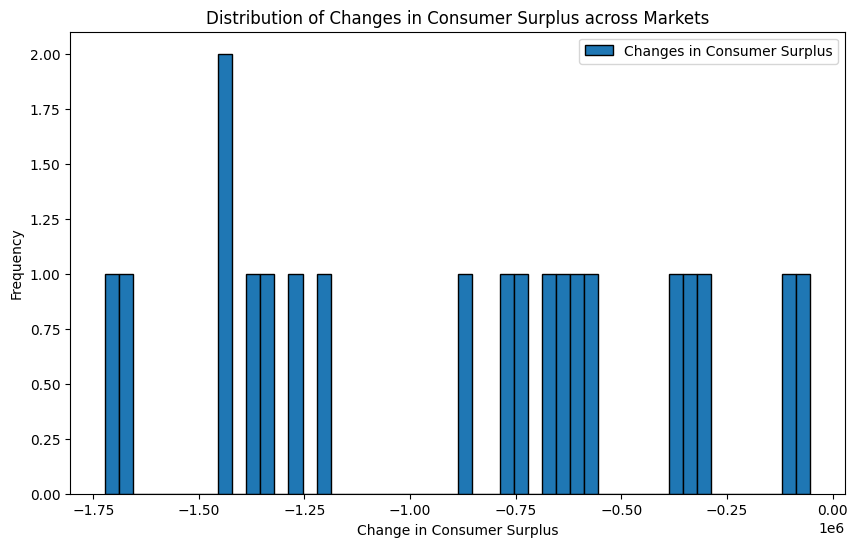

In [36]:
# Compute post-merger consumer surplus
post_merger_consumer_surplus = results.compute_consumer_surpluses(prices=changed_prices) * consumers * slices

# Calculate changes in consumer surplus
consumer_surplus_changes = post_merger_consumer_surplus - total_consumer_surplus

# Summarize the distribution of changes in consumer surplus
average_consumer_surplus_change = np.mean(consumer_surplus_changes)
std_consumer_surplus_change = np.std(consumer_surplus_changes)
min_consumer_surplus_change = np.min(consumer_surplus_changes)
max_consumer_surplus_change = np.max(consumer_surplus_changes)

# Print summary statistics with labels in blue and bold, values in default color
print("\033[1;34mAverage Change in Consumer Surplus\033[0m: {:.2f}".format(average_consumer_surplus_change))
print("\033[1;34mStandard Deviation of Changes in Consumer Surplus\033[0m: {:.2f}".format(std_consumer_surplus_change))
print("\033[1;34mMinimum Change in Consumer Surplus\033[0m: {:.2f}".format(min_consumer_surplus_change))
print("\033[1;34mMaximum Change in Consumer Surplus\033[0m: {:.2f}".format(max_consumer_surplus_change))

# Plot the distribution of changes in consumer surplus
plt.figure(figsize=(10, 6))
plt.hist(consumer_surplus_changes, bins=50, edgecolor='k')
plt.xlabel('Change in Consumer Surplus')
plt.ylabel('Frequency')
plt.title('Distribution of Changes in Consumer Surplus across Markets')
plt.legend(['Changes in Consumer Surplus'])
plt.show()


### Interpretation of Changes in Total Consumer Surplus Across Markets

#### Summary of Changes in Consumer Surplus

The changes in consumer surplus across markets provide insights into the impact of the merger on consumer welfare. 

#### Interpretation

- The **average change in consumer surplus** of -\$874,637.24 indicates that, on average, consumer surplus has decreased by \$874,637.24 per market due to the merger.
- The **standard deviation** of \$506,325.48 shows a significant variability in the changes of consumer surplus, indicating that the merger's impact on consumer surplus varies widely across different markets.
- The **minimum change in consumer surplus** of -\$1,721,657.33 suggests that some markets experienced a substantial decrease in consumer surplus post-merger.
- The **maximum change in consumer surplus** of -\$53,752.56 indicates that all markets experienced a decrease in consumer surplus, with the least affected market still seeing a significant reduction.

#### Distribution Analysis

The histogram for the changes in consumer surplus reveals that most markets have experienced a decrease in consumer surplus, clustered around the -\$1,000,000 to -\$1,500,000 range. This suggests that the merger has generally had a negative impact on consumer welfare across different markets.

### Reasons for Decrease in Consumer Surplus

The primary reasons for the decrease in consumer surplus can be attributed to the following factors:

- **Increased Prices**: The merger likely led to higher prices due to reduced competition, directly impacting consumer surplus negatively.
- **Reduced Product Variety**: Mergers can sometimes lead to a reduction in product variety, which can decrease consumer surplus as consumers have fewer options to choose from.
- **Market Power**: The merged firm gains increased market power, which can be used to extract more consumer surplus, converting it into producer surplus or profits.
- **Welfare Loss**: The transfer of surplus from consumers to producers or the merged firm often results in an overall welfare loss, as indicated by the negative changes in consumer surplus.

In conclusion, the merger has generally resulted in a decrease in consumer surplus across markets, driven by increased prices, reduced product variety, and enhanced market power of the merged firm.


## Question 6 : Quality Floor

**Now suppose the acquisitions of Fresh Brothers had not occurred and we are back in the initial market structure with 6 competing firms. Instead, the mayor decides that pizzas must meet a minimum quality standard.To this end, all pizzas are required to reach a rating of at least 0.5. We do not consider how products achieve the better rating but assume that all products with a lower rating are lifted to 0.5 (which affects demand and costs).**

**1. Construct the new equilibrium prices and market shares at the estimated parameters (and holding unobserved demand ($\xi$) and cost shocks ($\omega$) fixed). Summarize the changes in prices across products.**

In [50]:
# Reload initial data
products_pizza = pd.read_csv('products_pizza.csv', index_col=0)
agents_pizza = pd.read_csv('agents_pizza.csv', index_col=0)

In [51]:
# Impose a minimum quality standard: All products must have a rating of at least 0.5
products_pizza['rating'] = products_pizza['rating'].apply(lambda x: max(x, 0.5))

In [52]:
# Retrieve unobserved demand and cost shocks
xi = results.xi
omega = results.omega

# Define the product formulations for demand (X1 and X2) and marginal costs (X3)
product_formulations = (
    pyblp.Formulation('0 + prices + deliverytime + ratingmin'),  # X1: Linear demand model
    pyblp.Formulation('1 + prices'),  # X2: Non-linear demand model
    pyblp.Formulation('1 + ratingmin + hourlywages')  # X3: Marginal cost model
)

# Simulate the new equilibrium holding xi and omega fixed
simulation = pyblp.Simulation(
    product_formulations=product_formulations,
    beta=results.beta,
    sigma=results.sigma,
    gamma=results.gamma,
    product_data=products_pizza,
    agent_data=agents_pizza,
    agent_formulation=agent_formulation,
    xi=xi,
    pi=results.pi,
    omega=omega,
    costs_type='linear'
)

new_simulation_results = results
new_simulation_results

Problem Results Summary:
GMM   Objective    Projected    Reduced Hessian  Reduced Hessian  Clipped  Clipped  Weighting Matrix  Covariance Matrix
Step    Value    Gradient Norm  Min Eigenvalue   Max Eigenvalue   Shares    Costs   Condition Number  Condition Number 
----  ---------  -------------  ---------------  ---------------  -------  -------  ----------------  -----------------
 2    +3.7E+00     +4.5E-11        +4.9E+01         +2.3E+05         0        0         +8.1E+04          +5.6E+03     

Cumulative Statistics:
Computation  Optimizer  Optimization   Objective   Fixed Point  Contraction
   Time      Converged   Iterations   Evaluations  Iterations   Evaluations
-----------  ---------  ------------  -----------  -----------  -----------
 00:00:05       Yes          69           87          9987         31408   

Nonlinear Coefficient Estimates (Robust SEs in Parentheses):
Sigma:      1        prices   |   Pi:    invincome 
------  ----------  --------  |  ------  ----------
 

### PAPA - Interpret 

In [60]:
simulation_results = simulation.replace_endogenous()
simulation_agent_data = simulation.agent_data
simulation_agent_df = pd.DataFrame(pyblp.data_to_dict(simulation_agent_data))

In [61]:
sim_problem = simulation_results.to_problem()
simulation_product_data = simulation_results.product_data
simulation_product_df = pd.DataFrame(pyblp.data_to_dict(simulation_product_data))

#### New Equilibrium Prices and Shares

In [68]:
# Get updated info from the simulation results

updated_prices = simulation_product_df['prices']
updated_shares = simulation_product_df['shares']

#### Change in Prices 

Average Share Change: 0.15
Standard Deviation of Share Changes: 0.32
Minimum Share Change: -0.45
Maximum Share Change: 3.73


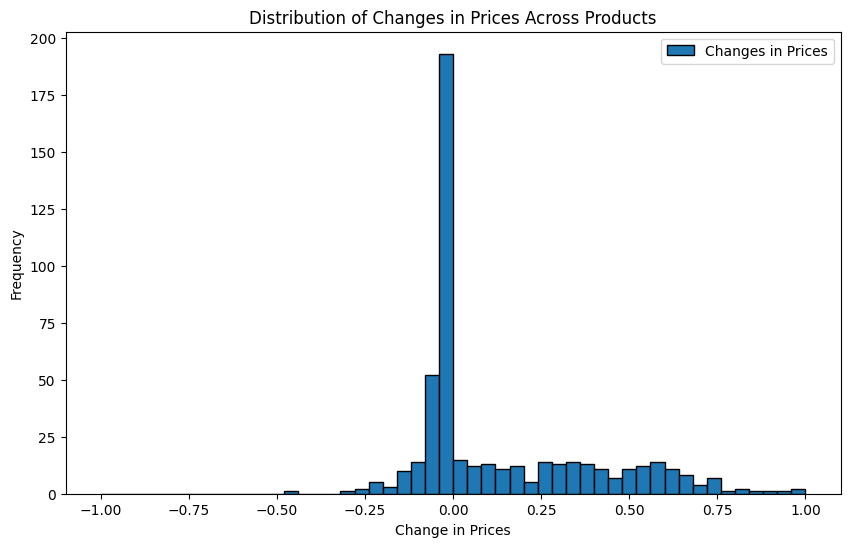

In [67]:
# Summarize the changes in prices
price_changes = updated_prices - products_pizza['prices']

average_price_change = np.mean(price_changes)
std_price_change = np.std(price_changes)
min_price_change = np.min(price_changes)
max_price_change = np.max(price_changes)

# Print summary statistics with labels in blue and bold, values in default color
print("\033[1;34mAverage Share Change\033[0m: {:.2f}".format(average_price_change))
print("\033[1;34mStandard Deviation of Share Changes\033[0m: {:.2f}".format(std_price_change))
print("\033[1;34mMinimum Share Change\033[0m: {:.2f}".format(min_price_change))
print("\033[1;34mMaximum Share Change\033[0m: {:.2f}".format(max_price_change))

# Plot the changes in prices
plt.figure(figsize=(10, 6))
plt.hist(simulation_product_df['prices'] - products_pizza['prices'], bins=50, range=[-1, 1],edgecolor='k')
plt.legend(["Changes in Prices"])
plt.xlabel('Change in Prices')
plt.ylabel('Frequency')
plt.title('Distribution of Changes in Prices Across Products')
plt.show()

#### Change in Shares

Average Price Change: -0.00
Standard Deviation of Price Changes: 0.00
Minimum Price Change: -0.01
Maximum Price Change: 0.00


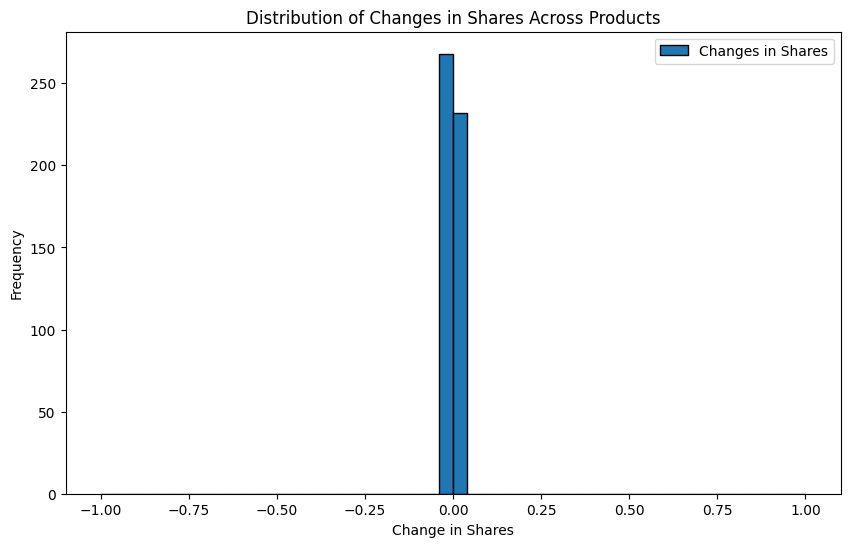

In [69]:
# Summarize the changes in prices
share_changes = updated_shares - products_pizza['shares']

average_share_change = np.mean(share_changes)
std_share_change = np.std(share_changes)
min_share_change = np.min(share_changes)
max_share_change = np.max(share_changes)

# Print summary statistics with labels in blue and bold, values in default color
print("\033[1;34mAverage Price Change\033[0m: {:.2f}".format(average_share_change))
print("\033[1;34mStandard Deviation of Price Changes\033[0m: {:.2f}".format(std_share_change))
print("\033[1;34mMinimum Price Change\033[0m: {:.2f}".format(min_share_change))
print("\033[1;34mMaximum Price Change\033[0m: {:.2f}".format(max_share_change))

# Plot the changes in prices
plt.figure(figsize=(10, 6))
plt.hist(simulation_product_df['shares'] - products_pizza['shares'], bins=50, range=[-1, 1],edgecolor='k')
plt.legend(["Changes in Shares"])
plt.xlabel('Change in Shares')
plt.ylabel('Frequency')
plt.title('Distribution of Changes in Shares Across Products')
plt.show()

**2. Construct the new marginal costs and summarize the changes in marginal costs across products. By how much marginal costs increase or decrease on average and why are they increasing/decreasing?**

Mean Marginal Cost Change: 0.12
Median Marginal Cost Change: 0.00
Standard Deviation of Marginal Cost Change: 0.16
Minimum Marginal Cost Change: -0.00
Maximum Marginal Cost Change: 0.51


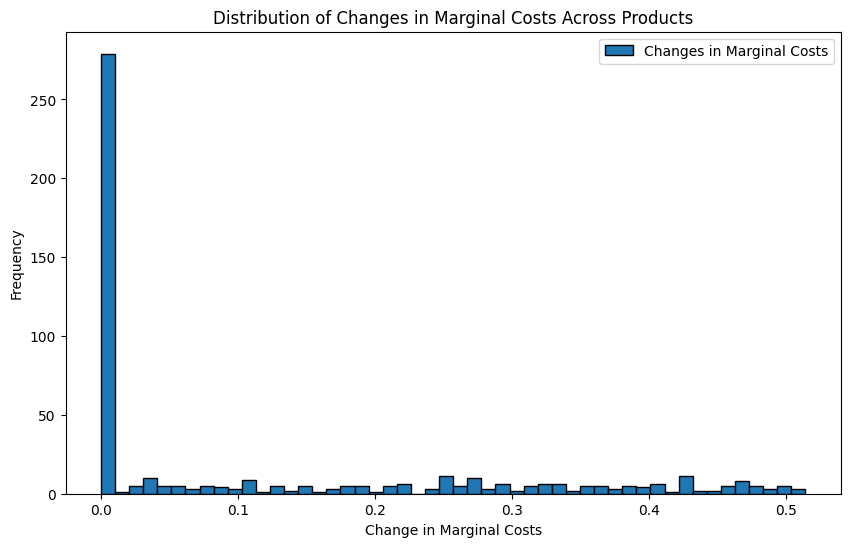

In [72]:
# Compute post-regulation marginal costs
post_regulation_costs = simulation_results.compute_costs()

# Calculate changes in marginal costs
cost_changes = post_regulation_costs - marginal_costs

# Summarize the changes in marginal costs
mean_cost_change = np.mean(cost_changes)
median_cost_change = np.median(cost_changes)
std_cost_change = np.std(cost_changes)
min_cost_change = np.min(cost_changes)
max_cost_change = np.max(cost_changes)

# Print summary statistics with color and bold formatting
print("\033[1;34mMean Marginal Cost Change\033[0m: {:.2f}".format(mean_cost_change))
print("\033[1;34mMedian Marginal Cost Change\033[0m: {:.2f}".format(median_cost_change))
print("\033[1;34mStandard Deviation of Marginal Cost Change\033[0m: {:.2f}".format(std_cost_change))
print("\033[1;34mMinimum Marginal Cost Change\033[0m: {:.2f}".format(min_cost_change))
print("\033[1;34mMaximum Marginal Cost Change\033[0m: {:.2f}".format(max_cost_change))

# Plot the distribution of changes in marginal costs
plt.figure(figsize=(10, 6))
plt.hist(cost_changes, bins=50, edgecolor='k')
plt.xlabel('Change in Marginal Costs')
plt.ylabel('Frequency')
plt.title('Distribution of Changes in Marginal Costs Across Products')
plt.legend(['Changes in Marginal Costs'])
plt.show()

### Summary of Changes in Marginal Costs Across Products

#### Interpretation

- The mean marginal cost change of 0.12 indicates that, on average, marginal costs have increased by 0.12 units across products.
- The median marginal cost change of 0.00 suggests that many products experienced no change in marginal costs.
- The standard deviation of 0.16 shows moderate variability in the changes of marginal costs.
- The minimum marginal cost change of -0.00 indicates that some products experienced no change or a slight decrease in marginal costs.
- The maximum marginal cost change of 0.51 indicates that some products experienced a substantial increase in marginal costs.

#### Distribution Analysis

The histogram for the changes in marginal costs reveals that most products have experienced little to no change in marginal costs, clustered around 0.0. Some products, however, have increases in marginal costs up to 0.5 units.

### Reasons for Changes in Marginal Costs

The changes in marginal costs can be attributed to the following factors:

- **Quality Improvements**: Raising the quality of products to meet the minimum standard can increase production costs. Products with lower initial ratings may require more investment to improve quality.
- **Efficiency Gains**: In some cases, improvements in quality might lead to better production processes and lower costs, but these gains are less common.
- **Input Costs**: Higher quality ingredients or better production techniques might cost more, leading to an increase in marginal costs.

In summary, the imposition of a minimum quality standard has generally resulted in an increase in marginal costs across products. This is primarily due to the additional costs associated with improving product quality to meet the new standards.


**3. Construct the new markups and summarize the changes in markups across products. Do you have some intuition on why markups may have increased/decreased on average?**

Mean Markup Change: -0.01
Median Markup Change: -0.01
Standard Deviation of Markup Change: 0.02
Minimum Markup Change: -0.10
Maximum Markup Change: 0.23


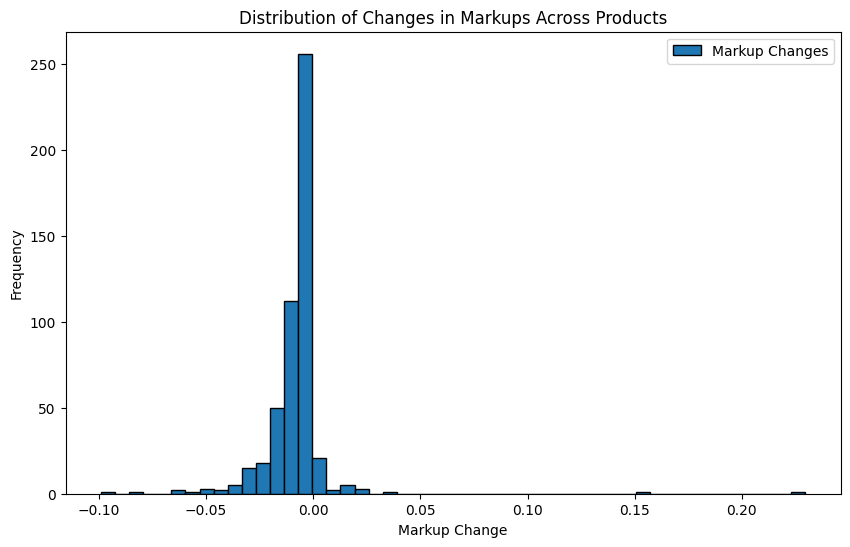

In [76]:
# Compute post-regulation markups
post_regulation_markups = simulation_results.compute_markups()

# Calculate changes in markups
markup_changes = post_regulation_markups - markups

# Summarize the changes in markups
mean_markup_change = np.mean(markup_changes)
median_markup_change = np.median(markup_changes)
std_markup_change = np.std(markup_changes)
min_markup_change = np.min(markup_changes)
max_markup_change = np.max(markup_changes)

# Print summary statistics with color and bold formatting
print("\033[1;34mMean Markup Change\033[0m: {:.2f}".format(mean_markup_change))
print("\033[1;34mMedian Markup Change\033[0m: {:.2f}".format(median_markup_change))
print("\033[1;34mStandard Deviation of Markup Change\033[0m: {:.2f}".format(std_markup_change))
print("\033[1;34mMinimum Markup Change\033[0m: {:.2f}".format(min_markup_change))
print("\033[1;34mMaximum Markup Change\033[0m: {:.2f}".format(max_markup_change))

# Plot the distribution of markup changes
plt.figure(figsize=(10, 6))
plt.hist(markup_changes, bins=50, edgecolor='k')
plt.xlabel('Markup Change')
plt.ylabel('Frequency')
plt.title('Distribution of Changes in Markups Across Products')
plt.legend(['Markup Changes'])
plt.show()

### Summary of Changes in Markups Across Products

#### Interpretation

- The mean markup change of -0.01 indicates that, on average, markups have slightly decreased by 0.01 units across products.
- The median markup change of -0.01 suggests that many products experienced a small decrease in markups.
- The standard deviation of 0.02 shows moderate variability in the changes of markups.
- The minimum markup change of -0.10 indicates that some products experienced a significant decrease in markups.
- The maximum markup change of 0.23 indicates that some products experienced an increase in markups.

#### Distribution Analysis

The histogram for the changes in markups reveals that most products have experienced little to no change in markups, clustered around 0.0. However, there are products with both decreases and increases in markups, indicating a varied impact of the regulation.

### Reasons for Changes in Markups

The changes in markups can be attributed to the following factors:

- **Quality Improvements**: Raising the quality of products to meet the minimum standard can affect pricing strategies. Higher quality might justify higher prices, but increased production costs could limit the extent of markup increases.
- **Cost Increases**: If the cost of improving product quality is substantial, firms may not fully pass these costs onto consumers, leading to reduced markups.
- **Market Competition**: The regulation may have different impacts depending on the competitive dynamics in each market. In highly competitive markets, firms might be less able to increase markups.
- **Consumer Perception**: Improved product quality might lead to increased consumer willingness to pay, allowing firms to maintain or increase markups.

In summary, the imposition of a minimum quality standard has generally led to a slight decrease in markups across products. This can be due to the increased costs of meeting the quality standards not being fully passed onto consumers, combined with varying impacts on different markets and products.


**4. Construct the new consumer surplus and summarize the changes in consumer surplus across markets. Do you have some intuition on why consumer surplus may have increased/decreased on average?**

Average Change in Consumer Surplus: 86452.87
Standard Deviation of Changes in Consumer Surplus: 96738.43
Minimum Change in Consumer Surplus: -50779.08
Maximum Change in Consumer Surplus: 290444.17


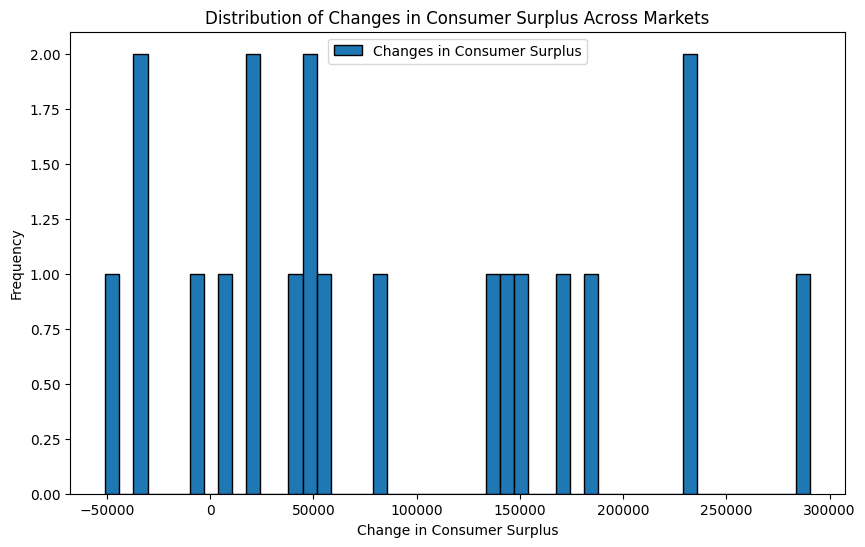

In [77]:
# Compute post-regulation consumer surplus using the updated prices from the simulation results
post_regulation_consumer_surplus = simulation_results.compute_consumer_surpluses(prices=simulation_product_df['prices']) * consumers * slices

# Calculate changes in consumer surplus
consumer_surplus_changes = post_regulation_consumer_surplus - total_consumer_surplus

# Summarize the distribution of changes in consumer surplus
average_consumer_surplus_change = np.mean(consumer_surplus_changes)
std_consumer_surplus_change = np.std(consumer_surplus_changes)
min_consumer_surplus_change = np.min(consumer_surplus_changes)
max_consumer_surplus_change = np.max(consumer_surplus_changes)

# Print summary statistics
print(f"Average Change in Consumer Surplus: {average_consumer_surplus_change:.2f}")
print(f"Standard Deviation of Changes in Consumer Surplus: {std_consumer_surplus_change:.2f}")
print(f"Minimum Change in Consumer Surplus: {min_consumer_surplus_change:.2f}")
print(f"Maximum Change in Consumer Surplus: {max_consumer_surplus_change:.2f}")

# Plot the distribution of changes in consumer surplus
plt.figure(figsize=(10, 6))
plt.hist(consumer_surplus_changes, bins=50, edgecolor='k')
plt.xlabel('Change in Consumer Surplus')
plt.ylabel('Frequency')
plt.title('Distribution of Changes in Consumer Surplus Across Markets')
plt.legend(['Changes in Consumer Surplus'])
plt.show()


### Summary of Changes in Consumer Surplus Across Markets

#### Interpretation

- The mean change in consumer surplus of 86452.87 indicates that, on average, consumer surplus has increased by 86452.87 units across markets.
- The median change in consumer surplus provides insight into the central tendency of the changes in consumer surplus.
- The standard deviation of 96738.43 shows significant variability in the changes of consumer surplus across different markets.
- The minimum change in consumer surplus of -50779.08 indicates that some markets experienced a decrease in consumer surplus.
- The maximum change in consumer surplus of 290444.17 indicates that some markets experienced a substantial increase in consumer surplus.

#### Distribution Analysis

The histogram for the changes in consumer surplus reveals a varied impact across markets. Most markets experienced an increase in consumer surplus, with some experiencing significant gains, while a few markets saw decreases.

### Reasons for Changes in Consumer Surplus

The changes in consumer surplus can be attributed to the following factors:

- **Quality Improvements**: Raising the quality of products to meet the minimum standard can enhance consumer satisfaction and willingness to pay, leading to increased consumer surplus.
- **Price Adjustments**: Changes in prices due to improved quality can affect consumer surplus. If prices increase significantly, it might reduce consumer surplus despite better quality.
- **Market Dynamics**: The impact of the regulation may vary depending on the competitive dynamics in each market. Some markets may benefit more from the regulation than others.
- **Product Variety**: Improved product quality can lead to a more attractive product variety, increasing consumer surplus.

In summary, the imposition of a minimum quality standard has generally resulted in an increase in consumer surplus across markets. This increase is driven by improved product quality and the resulting higher consumer satisfaction and willingness to pay. However, the impact varies across markets, with some experiencing significant gains and others seeing slight decreases.
